In [1]:
!pip install pandas matplotlib seaborn holidays lightgbm unidecode joblib xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from unidecode import unidecode
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import holidays

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10000)

# CARREGA OS DADOS DE TREINAMENTO
print("Carregando e preparando os dados...")
df = pd.read_csv('acidentes_2017_a_2025.csv', sep=';', encoding='windows-1252',low_memory=False)
print("Dados carregados...")

Carregando e preparando os dados...
Dados carregados...


In [3]:
# EDA - Análise Exploratória de Dados

print('--- Iniciando a análise exploratória de dados ---')
print('--- Iniciando a Engenharia de Features ---')

# O Arquivo possui as seguintes features/classe:
# id => Variável com valores numéricos, representando o identificador do acidente.
# pesid => Variável com valores numéricos, representando o identificador da pessoa envolvida.
# data_inversa => Data da ocorrência no formato dd/mm/aaaa.
# dia_semana => Dia da semana da ocorrência. Ex.: Segunda, Terça, etc.
# horario => Horário da ocorrência no formato hh:mm:ss.
# uf => Unidade da Federação. Ex.: MG, PE, DF, etc.
# br => Variável com valores numéricos, representando o identificador da BR do acidente.
# km => Identificação do quilômetro onde ocorreu o acidente, com valor mínimo de 0,1 km e com a casa decimal separada por ponto.
# municipio => Nome do município de ocorrência do acidente
# causa_principal => Identifica se a causa do acidente foi identificada como principal pelo policial.
# causa_acidente => Causa presumível do acidente, baseada nos vestígios, indícios e provas colhidas no local do acidente.
# ordem_tipo_acidente => Valor numérico que identifica a sequência dos eventos sucessivos que ocorreram no acidente.
# tipo_acidente => Identificação do tipo de acidente. Ex.: Colisão frontal, Saída de pista, etc.
# classificação_acidente => Classificação quanto à gravidade do acidente: Sem Vítimas, Com Vítimas Feridas, Com Vítimas Fatais e Ignorado.
# fase_dia => Fase do dia no momento do acidente. Ex. Amanhecer, Pleno dia, etc.
# sentido_via => Sentido da via considerando o ponto de colisão: Crescente e decrescente.
# condição_meteorologica Condição meteorológica no momento do acidente: Céu claro, chuva, vento, etc.
# tipo_pista => Tipo da pista considerando a quantidade de faixas: Dupla, simples ou múltipla.
# tracado_via => Descrição do traçado da via.
# uso_solo => Descrição sobre as características do local do acidente: Urbano=Sim;Rural=Não.
# id_veiculo => Variável com valores numéricos, representando o identificador do veículo envolvido.
# tipo_veiculo => Tipo do veículo conforme Art. 96 do Código de Trânsito Brasileiro. Ex.: Automóvel, Caminhão, Motocicleta, etc.
# marca => Descrição da marca do veículo.
# ano_fabricacao_veiculo => Ano de fabricação do veículo, formato aaaa
# tipo_envolvido => Tipo de envolvido no acidente conforme sua participação no evento. Ex.: condutor, passageiro, pedestre, etc 
# estado_fisico => Condição do envolvido conforme a gravidade das lesões. Ex.: morto, ferido leve, etc.
# idade => Idade do envolvido. O código “-1” indica que não foi possível coletar tal informação.
# sexo => Sexo do envolvido. O valor “inválido” indica que não foi possível coletar tal informação.
# ilesos => Valor binário que identifica se o envolvido foi classificado como ileso.
# feridos_leves => Valor binário que identifica se o envolvido foi classificado como ferido leve.
# feridos_graves => Valor binário que identifica se o envolvido foi classificado como ferido grave.
# mortos => Valor binário que identifica se o envolvido foi classificado como morto.
# latitude => Latitude do local do acidente em formato geodésico decimal.
# longitude => Longitude do local do acidente em formato geodésico decimal.
# regional => Superintendência regional da PRF cujo acidente ocorreu dentro dos limites de sua circunscrição. Atenção nem sempre a UF da regional coincide com a UF do acidente. Ex: A circunscrição da SPRF- DF grande parte está localizada na UF “GO”.
# delegacia => delegacia da PRF cujo acidente ocorreu dentro dos limites de sua circunscrição.
# uop => UOP = unidade operacional. Unidade operacional da PRF cujo acidente ocorreu dentro dos limites de sua circunscrição.

# Remove todas as linhas duplicadas
df_clean = df.drop_duplicates(keep='first')

# Remove as colunas que não fazem sentido sendo:
df_clean = df.drop(columns=['id', 'pesid', 'causa_principal', 'ordem_tipo_acidente', 'sentido_via', 'uso_solo', 'id_veiculo', 'marca', 
                       'tipo_envolvido', 'estado_fisico', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos', 'regional', 'delegacia', 'uop'])

# Restringe o treinamento somente para o estado de PE - Pernambuco
df_clean = df_clean[(df_clean['uf'] == 'PE')]

# Restringe o treinamento somente na região metropolitana de PE
df_clean = df_clean[(df_clean['municipio'].isin(
[
    "ABREU E LIMA",
    "ARACOIABA",
    "CABO DE SANTO AGOSTINHO",
    "CAMARAGIBE",
    "IGARASSU",
    "ILHA DE ITAMARACA",
    "IPOJUCA",
    "ITAPISSUMA",
    "JABOATAO DOS GUARARAPES",
    "MORENO",
    "OLINDA",
    "PAULISTA",
    "RECIFE",
    "SAO LOURENCO DA MATA"
]))]

# Converte o campo data_inversa para datetime
df_clean['data_inversa'] = pd.to_datetime(df_clean['data_inversa'])
# Cria uma coluna de ano com a data convertida
df_clean['ano'] = df_clean['data_inversa'].dt.year
# Carrega somente os dados dos anos de 2023, 2024 e 2025 no dataframe
df_clean = df_clean[df_clean['ano'].isin([2023, 2024])]
# Elimina registros NaN (null) para as colunas tipo_acidente, classificacao_acidente, tipo_veiculo e br (rodovia)
df_clean = df_clean.dropna(subset=['tipo_acidente', 'classificacao_acidente', 'tipo_veiculo', 'br']).copy()


def tratar_texto(texto):
    '''
        Esta função tem o objetivo de remover qualquer caracter acentuado, ç, etc, deixando somente caracteres de A-Z 0-9.
    '''
    if isinstance(texto, str):
        return unidecode(texto).upper()
    return texto

def extrair_palavra_principal(texto):
    '''
        Esta função tem como objetivo extrair a primeira palavra de um tracado_via
        Exemplo: CURVA;ACLIVE, irá extrair CURVA
                 ACLIVE;CURVA, irá extrair ACLIVE
        Também realiza algumas substituições do tracado_via
    '''
    if pd.isna(texto):
        return np.nan
    
    primeiro_item = texto.split(';')[0].strip()
    palavras = primeiro_item.split()
    
    if not palavras:
        return np.nan
        
    if palavras[0] == 'EM':
        if len(palavras) > 1:
            return palavras[1].replace('VIADUTO', 'PONTE')
        else:
            return np.nan    
    else:
        return palavras[0].replace('VIADUTO', 'PONTE')

# Chama a função tratar_texto
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].apply(tratar_texto)

# Chama a função extrair_palavra_principal
df_clean['tracado_via_unico'] = df_clean['tracado_via'].apply(extrair_palavra_principal)

# Localiza idades superiores a 95 anos e menor que 14 anos e coloca NaN (null)
df_clean.loc[(df_clean['idade'] > 95) | (df_clean['idade'] < 14), 'idade'] = np.nan
# Remove idades que estão como NaN (null)
df_clean = df_clean.dropna(subset=['idade', ]).copy()
# Preenche todos os sexo com o valor NaN (null) para NAO INFORMADO
df_clean['sexo'] = df_clean['sexo'].fillna('NAO INFORMADO')
# Altera todos os textos IGNORADO para NAO INFORMADO
df_clean['sexo'] = df_clean['sexo'].str.replace('IGNORADO', 'NAO INFORMADO')

# Substitui 'CAMIONETA', 'UTILITARIO', 'CAMINHONETE' para 'AUTOMOVEL', pois estes veiculos possuem a mesma 'CATEGORIA'
valores_para_substituir = ['CAMIONETA', 'UTILITARIO', 'CAMINHONETE']
novo_valor = 'AUTOMOVEL'
df_clean['tipo_veiculo'] = df_clean['tipo_veiculo'].replace(valores_para_substituir, novo_valor)

# Substitui 'MOTONETA' para 'MOTOCICLETA', pois estes veiculos possuem a mesma 'CATEGORIA'
valores_para_substituir = ['MOTONETA']
novo_valor = 'MOTOCICLETA'
df_clean['tipo_veiculo'] = df_clean['tipo_veiculo'].replace(valores_para_substituir, novo_valor)

# Substitui 'SEMIREBOQUE', 'REBOQUE', 'CAMINHAO-TRATOR' para 'CAMINHAO', pois estes veiculos possuem a mesma 'CATEGORIA'
valores_para_substituir = ['SEMIREBOQUE', 'REBOQUE', 'CAMINHAO-TRATOR']
novo_valor = 'CAMINHAO'
df_clean['tipo_veiculo'] = df_clean['tipo_veiculo'].replace(valores_para_substituir, novo_valor)

# Substitui 'MICRO-ONIBUS' para 'ONIBUS', pois estes veiculos possuem a mesma 'CATEGORIA'
valores_para_substituir = ['MICRO-ONIBUS']
novo_valor = 'ONIBUS'
df_clean['tipo_veiculo'] = df_clean['tipo_veiculo'].replace(valores_para_substituir, novo_valor)

# Substitui 'CICLOMOTOR', 'MOTOR-CASA', 'TRATOR DE RODAS', 'CARROCA-CHARRETE', 'CHASSI-PLATAFORMA', 'TRICICLO', 'TREM-BONDE' , 
# 'TRATOR DE ESTEIRA', 'CARRO DE MAO', 'TRATOR MISTO', 'QUADRICICLO' PARA  para 'OUTROS', pois estes veiculos possuem a mesma 'CATEGORIA'
valores_para_substituir = ['CICLOMOTOR', 'MOTOR-CASA', 'TRATOR DE RODAS', 'CARROCA-CHARRETE', 'CHASSI-PLATAFORMA', 'TRICICLO', 'TREM-BONDE' , 'TRATOR DE ESTEIRA', 'CARRO DE MAO', 'TRATOR MISTO', 'QUADRICICLO' ]
novo_valor = 'OUTROS'
df_clean['tipo_veiculo'] = df_clean['tipo_veiculo'].replace(valores_para_substituir, novo_valor)

# Substitui 'PLENO DIA', 'AMANHECER' para 'DIA'
valores_para_substituir = ['PLENO DIA', 'AMANHECER']
novo_valor = 'DIA'
df_clean['fase_dia'] = df_clean['fase_dia'].replace(valores_para_substituir, novo_valor)

# Substitui 'PLENA NOITE', 'ANOITECER' para 'NOITE'
valores_para_substituir = ['PLENA NOITE', 'ANOITECER']
novo_valor = 'NOITE'
df_clean['fase_dia'] = df_clean['fase_dia'].replace(valores_para_substituir, novo_valor)

# Identifica final de semana na data e considera sexta-feira como final de semana
df_clean['final_semana'] = df_clean['data_inversa'].dt.weekday >= 4 

# Substitui a condicao_metereologica pela coluna condicao_tempo e quando o tempo está 'RUIM' muda o valor para ADVERSO
valores_para_substituir = ['NUBLADO', 'GAROA/CHUVISCO', 'CHUVA', 'VENTO', 'IGNORADO', 'NEVOEIRO/NEBLINA']
novo_valor = 'ADVERSO'
df_clean['condicao_tempo'] = df_clean['condicao_metereologica'].replace(valores_para_substituir, novo_valor)

# Substitui a condicao_metereologica pela coluna condicao_tempo e quando o tempo está 'BOM' muda o valor para NORMAL
valores_para_substituir = ['CEU CLARO', 'SOL']
novo_valor = 'NORMAL'
df_clean['condicao_tempo'] = df_clean['condicao_tempo'].replace(valores_para_substituir, novo_valor)

# Arredonda a coluna KM de 90,5 para 90
df_clean['km'] = np.ceil(df_clean['km'].str.replace(',','.').astype(float))

# Cria a nova coluna trecho_rodovia em trechos de 20 em 20km
df_clean['trecho_rodovia'] = 'BR-' + df_clean['br'].astype(str) + '_KM-' + (df_clean['km'] // 20 * 20).astype(str)

# Descobre os trechos que tem maiores números de acidentes
contagem_trechos = df_clean['trecho_rodovia'].value_counts()
top_50_trechos = contagem_trechos.head(50).index
# Classifica os 50 trechos com maiores incidencias formando o texto BR-101.0_KM-90.0 e os demais como OUTROS
df_clean['trecho_rodovia_agrupado'] = df_clean['trecho_rodovia'].apply(
    lambda x: x if x in top_50_trechos else 'OUTROS'
)

# Cria a feature rodovia juntando o municipio e a rodovia formando o texto RECIFE-BR-101
df_clean['rodovia'] = df_clean['municipio'].astype(str) + '-BR-' + df_clean['br'].astype(str)

# Substituir 'COM VITIMAS FERIDAS', 'COM VITIMAS FATAIS' para 'COM VITIMAS' a fim de ter somente duas classifições COM VITIMAS e SEM VITIMAS
valores_para_substituir = ['COM VITIMAS FERIDAS', 'COM VITIMAS FATAIS']
novo_valor = 'COM VITIMAS'
df_clean['classificacao_acidente'] = df_clean['classificacao_acidente'].replace(valores_para_substituir, novo_valor)

# Remove as colunas não usadas no treinamento, pois não apresentam ganho significativo
df_clean = df_clean.drop(columns=['horario', 'latitude', 'longitude', 'tracado_via', 'ano_fabricacao_veiculo', 'idade', 'dia_semana', 
                                  'condicao_metereologica', 'br', 'km','causa_acidente', 'data_inversa', 'sexo', 'uf', 'trecho_rodovia_agrupado', 
                                  'trecho_rodovia', 'municipio'])

print('\nColunas para processamento do treinamento do modelo\n')
print(df_clean.info())

print('\n--- Fim da Engenharia de Features ---')

# As features comentadas abaixo foram criadas mais não apresentaram ganhos significativos ao modelo.

# Imagine que você está usando a hora do dia como uma feature numérica (0, 1, 2, ..., 23). Para um modelo de machine learning, a distância numérica 
# entre a hora 23 e a hora 0 é grande (23). No entanto, na realidade, 23:00 e 00:00 são horários muito próximos, apenas uma hora de diferença.
# A solução é transformar a hora de uma forma que o modelo entenda essa natureza cíclica. A melhor maneira de fazer isso é mapear as 24 horas do dia 
# em um círculo, como o mostrador de um relógio.
# E como representamos um ponto em um círculo? Com suas coordenadas (x, y). A trigonometria nos dá exatamente as ferramentas para isso: seno e cosseno.
# df_clean['horario'] = pd.to_datetime(df_clean['horario'])
# df_clean['hora'] = df_clean['horario'].dt.hour
# df_clean['hora_sin'] = np.sin(2 * np.pi * df_clean['hora'] / 24)
# df_clean['hora_cos'] = np.cos(2 * np.pi * df_clean['hora'] / 24)
# df_clean['mes'] = df_clean['data_inversa'].dt.month

# df_clean['pista_tracado'] = df_clean['tipo_pista'] + '_' + df_clean['tracado_via_unico']
# df_clean['condicao_pista_tempo'] = df_clean['condicao_tempo'] + '_' + df_clean['pista_tracado']
# df_clean['fase_dia_fds'] = df_clean['fase_dia'] + '_' + df_clean['final_semana'].astype(str)
# df_clean['trecho_dia'] = df_clean['trecho_rodovia'] + '_' + df_clean['dia_semana']
# df_clean['fase_tempo'] = df_clean['fase_dia'] + '_' + df_clean['condicao_tempo']

# df_clean['trimestre'] = df_clean['data_inversa'].dt.quarter
# df_clean['dia_do_ano'] = df_clean['data_inversa'].dt.dayofyear
# df['semana_do_ano'] = df_clean['data_inversa'].dt.isocalendar().week
# br_holidays = holidays.Brazil()
# df['eh_feriado'] = df_clean['data_inversa'].apply(lambda date: date in br_holidays)
# df_clean['localizacao'] = df_clean['uf'].astype(str) + '-BR-'+ df_clean['br'].astype(str) + '-' + df_clean['km'].astype(str)

--- Iniciando a análise exploratória de dados ---
--- Iniciando a Engenharia de Features ---

Colunas para processamento do treinamento do modelo

<class 'pandas.core.frame.DataFrame'>
Index: 14795 entries, 330122 to 1502028
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   tipo_acidente           14795 non-null  object
 1   classificacao_acidente  14795 non-null  object
 2   fase_dia                14795 non-null  object
 3   tipo_pista              14795 non-null  object
 4   tipo_veiculo            14795 non-null  object
 5   ano                     14795 non-null  int32 
 6   tracado_via_unico       14795 non-null  object
 7   final_semana            14795 non-null  bool  
 8   condicao_tempo          14795 non-null  object
 9   rodovia                 14795 non-null  object
dtypes: bool(1), int32(1), object(8)
memory usage: 1.1+ MB
None

--- Fim da Engenharia de Features ---


A gerar gráfico de comparação para a coluna: classificacao_acidente


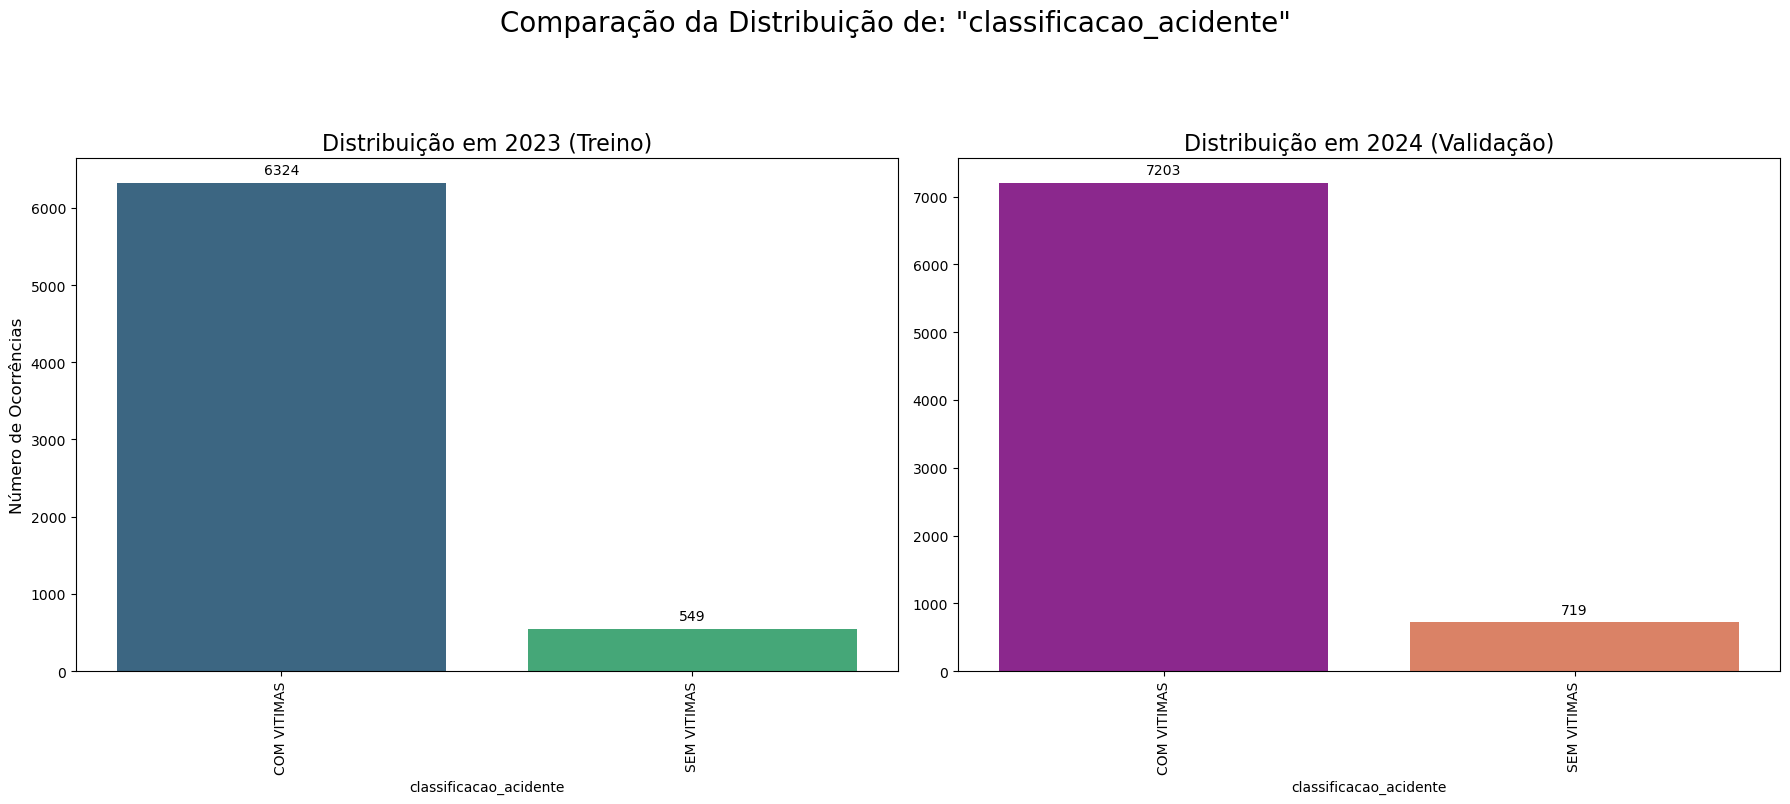

A gerar gráfico de comparação para a coluna: tipo_acidente


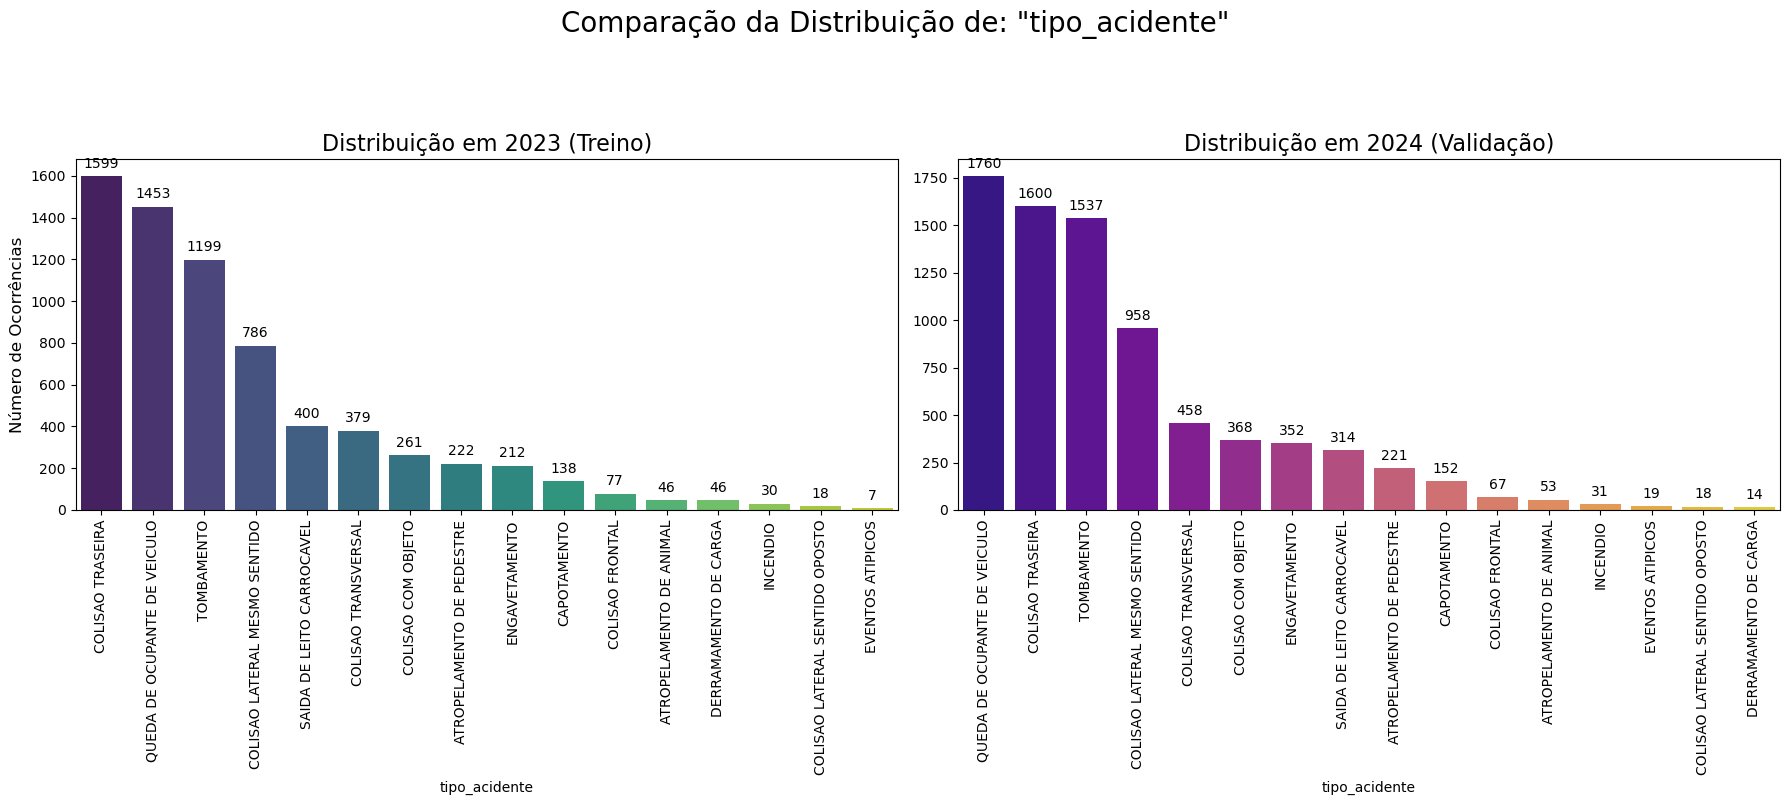

A gerar gráfico de comparação para a coluna: fase_dia


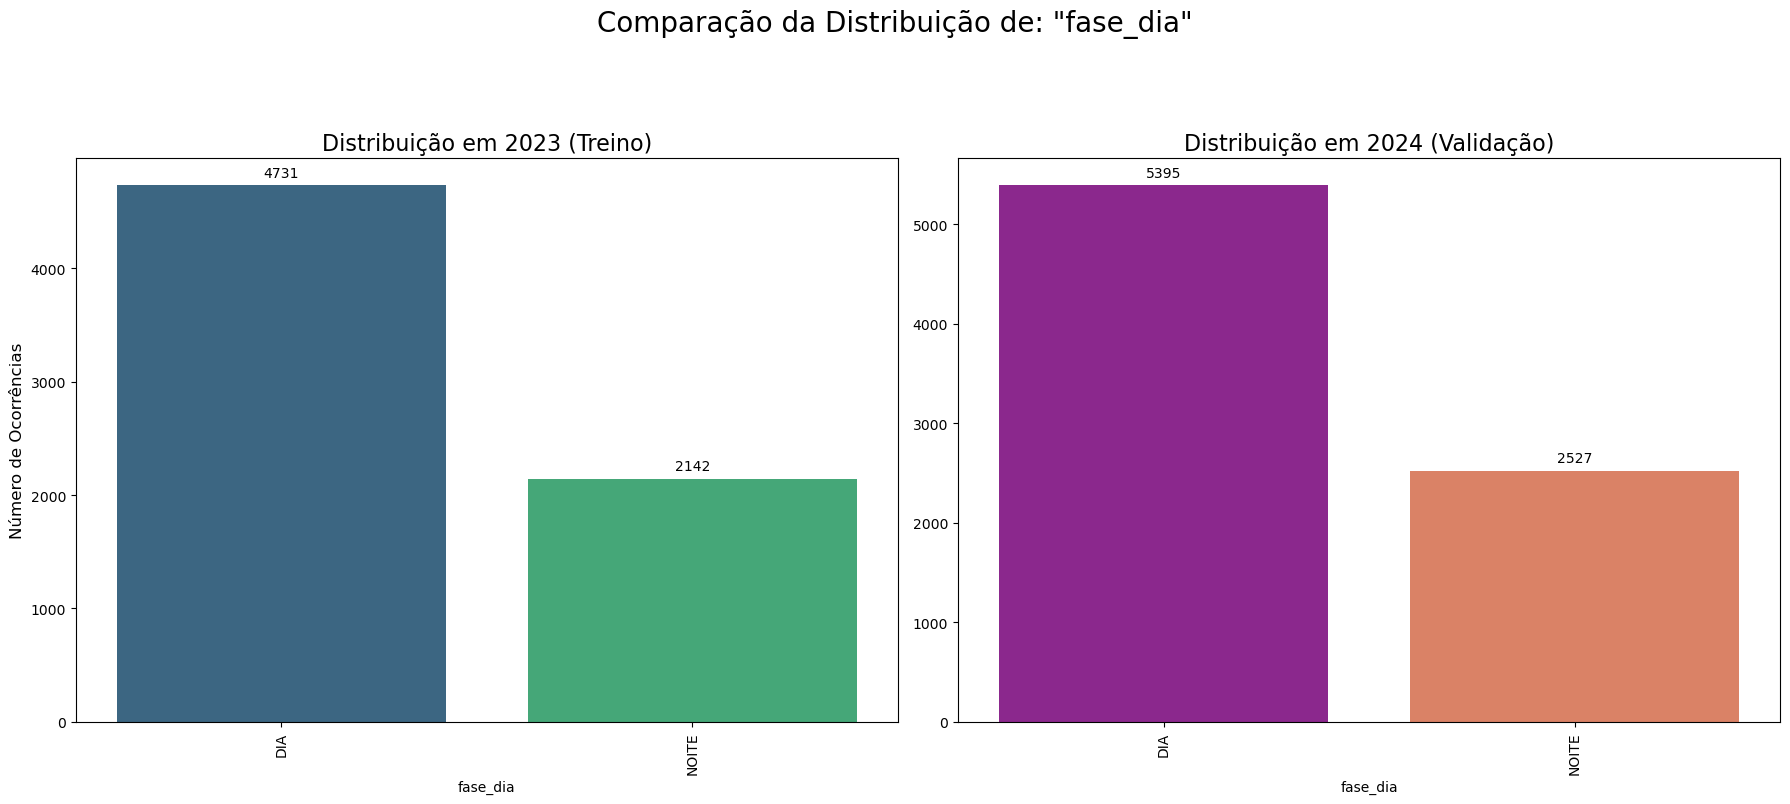

A gerar gráfico de comparação para a coluna: tipo_pista


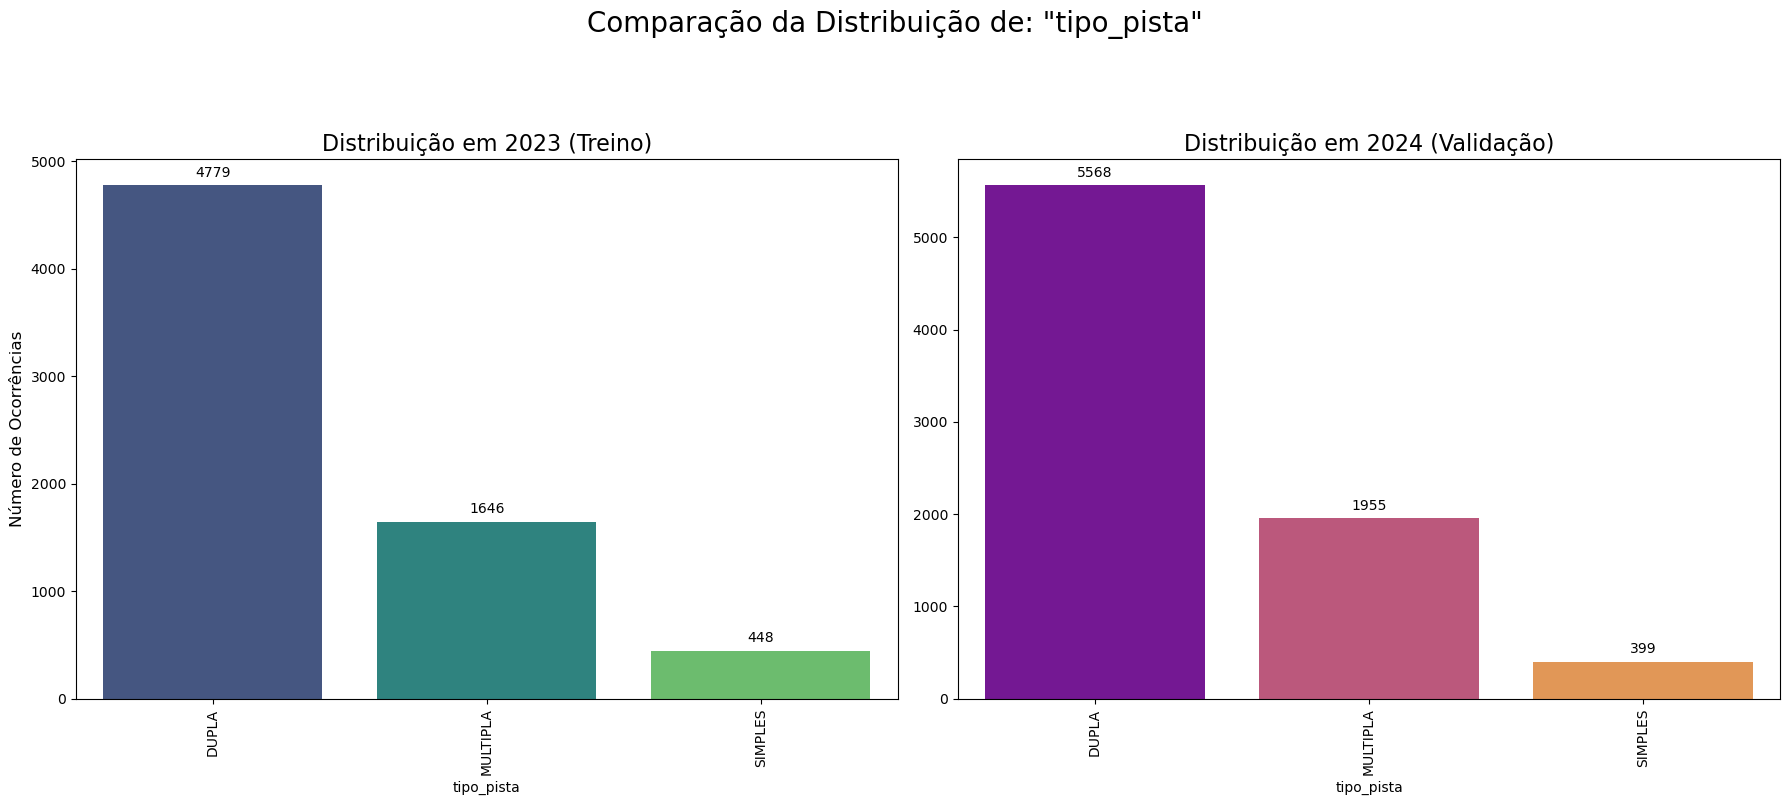

A gerar gráfico de comparação para a coluna: tipo_veiculo


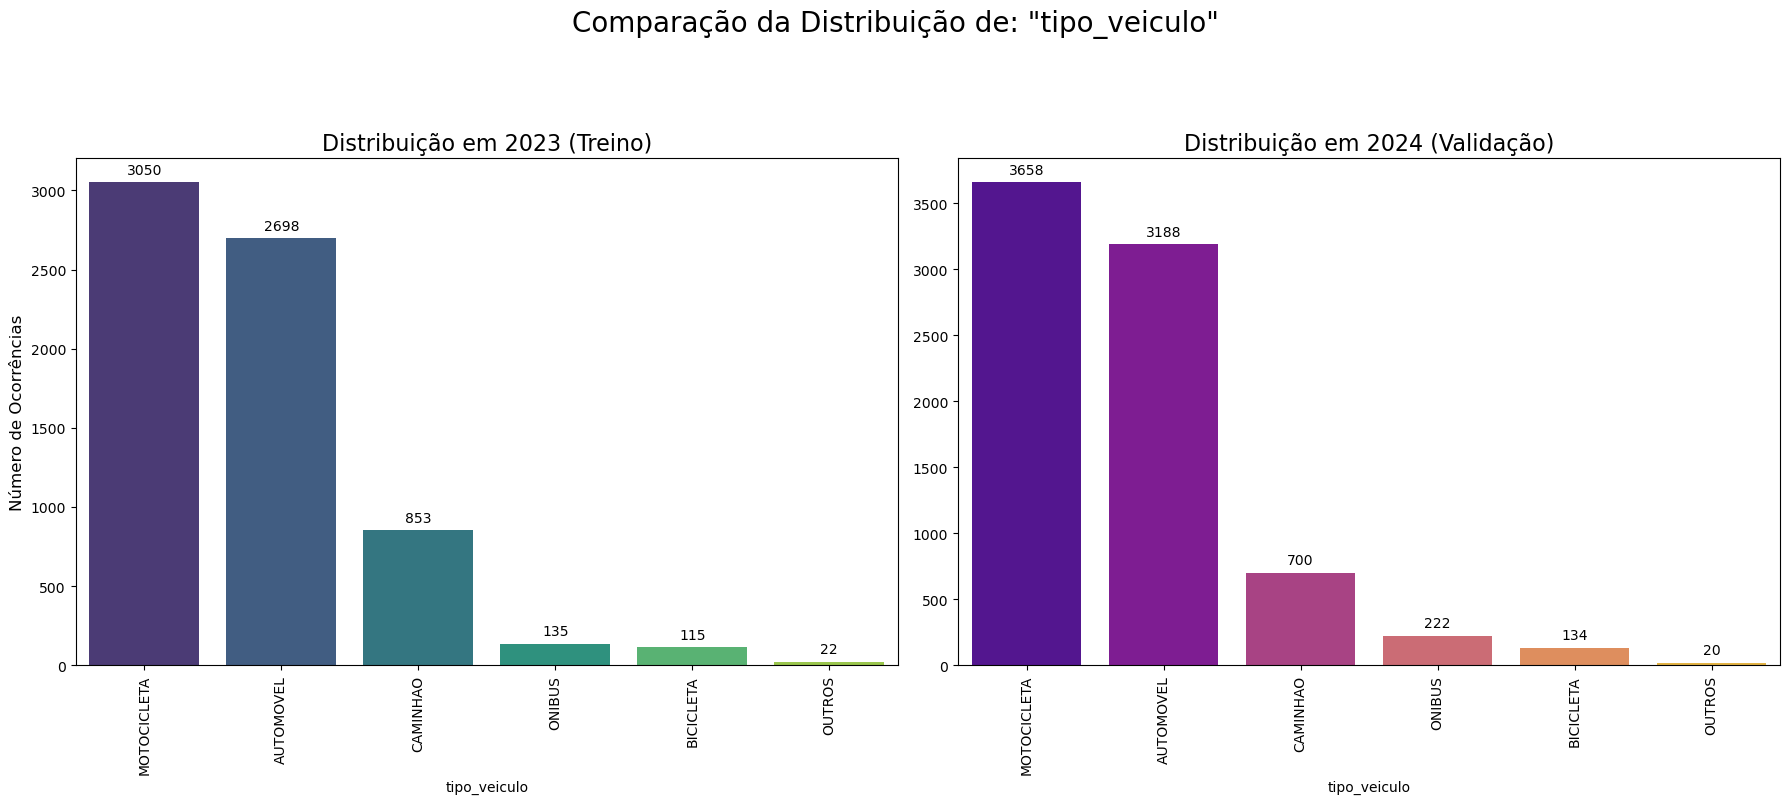

A gerar gráfico de comparação para a coluna: tracado_via_unico


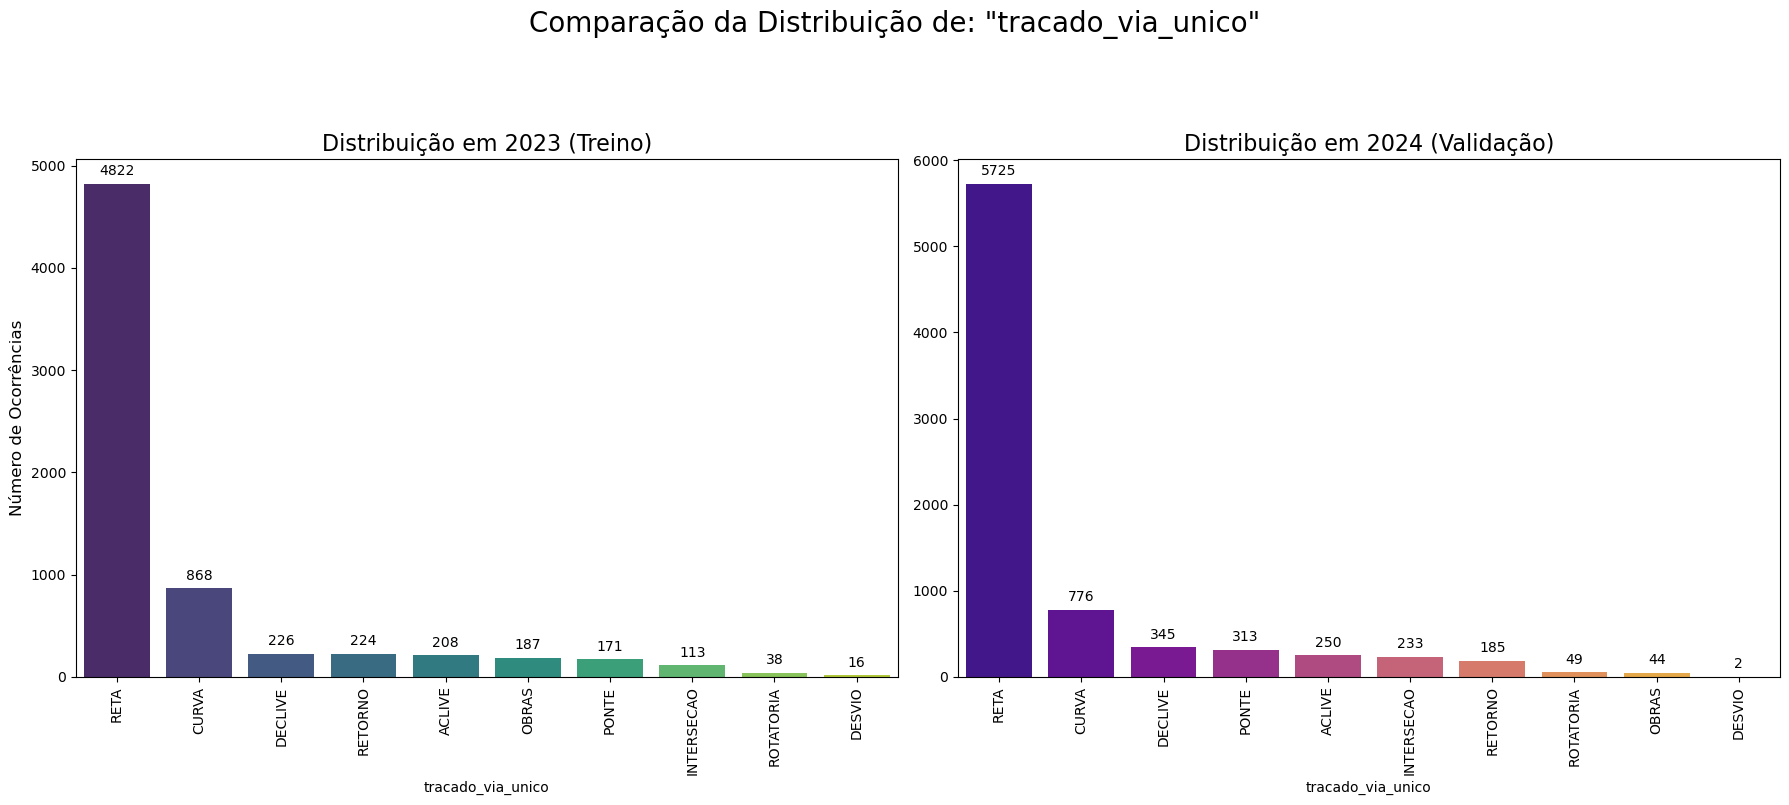

A gerar gráfico de comparação para a coluna: final_semana


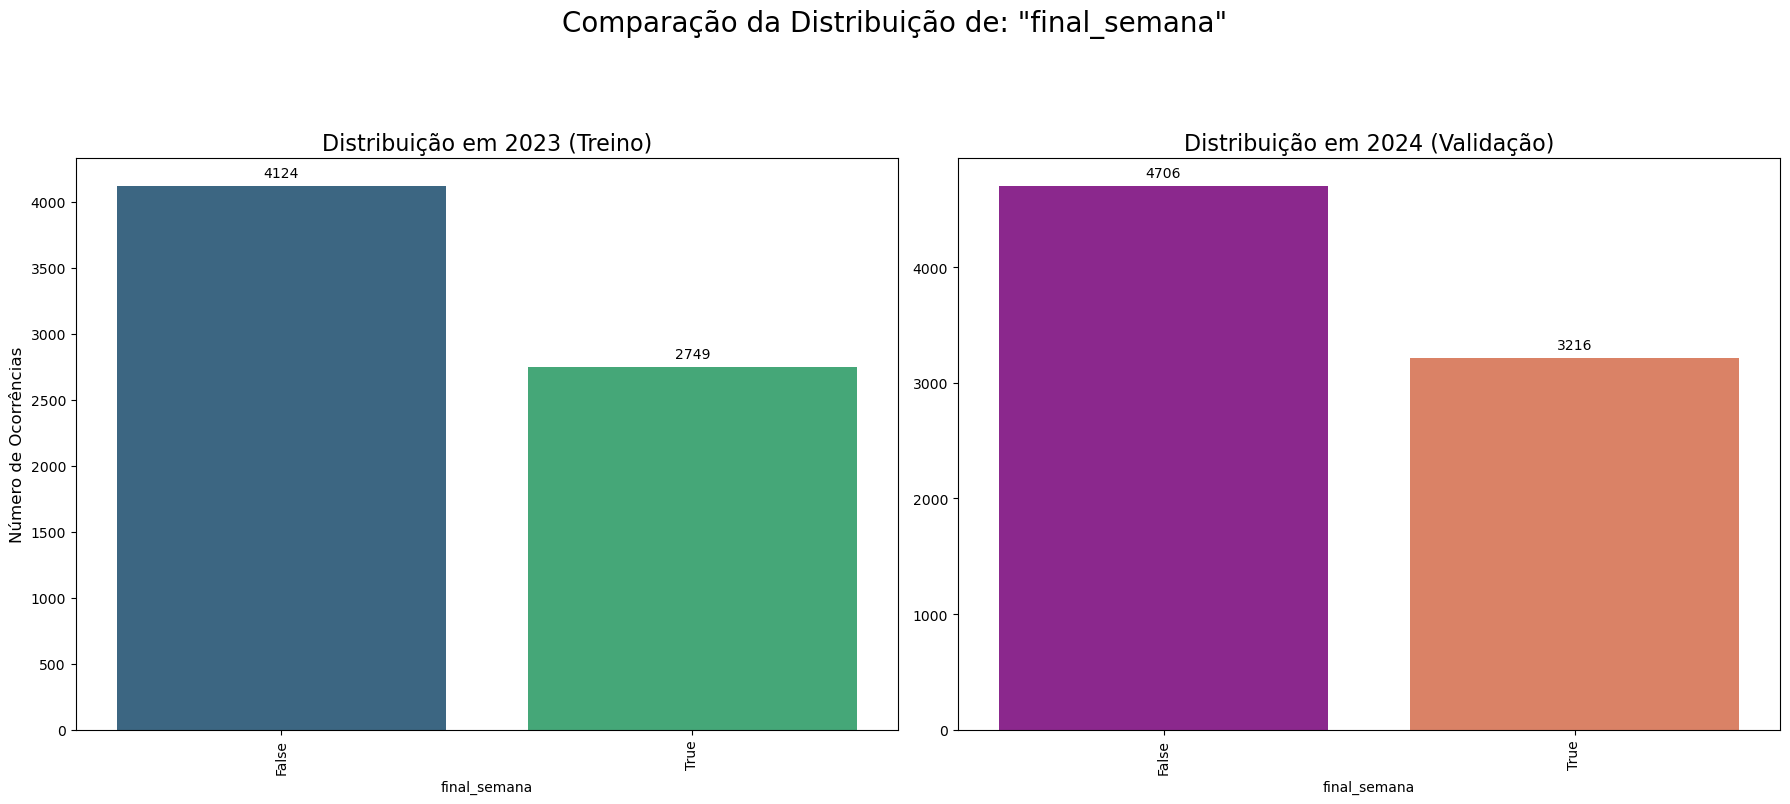

A gerar gráfico de comparação para a coluna: condicao_tempo


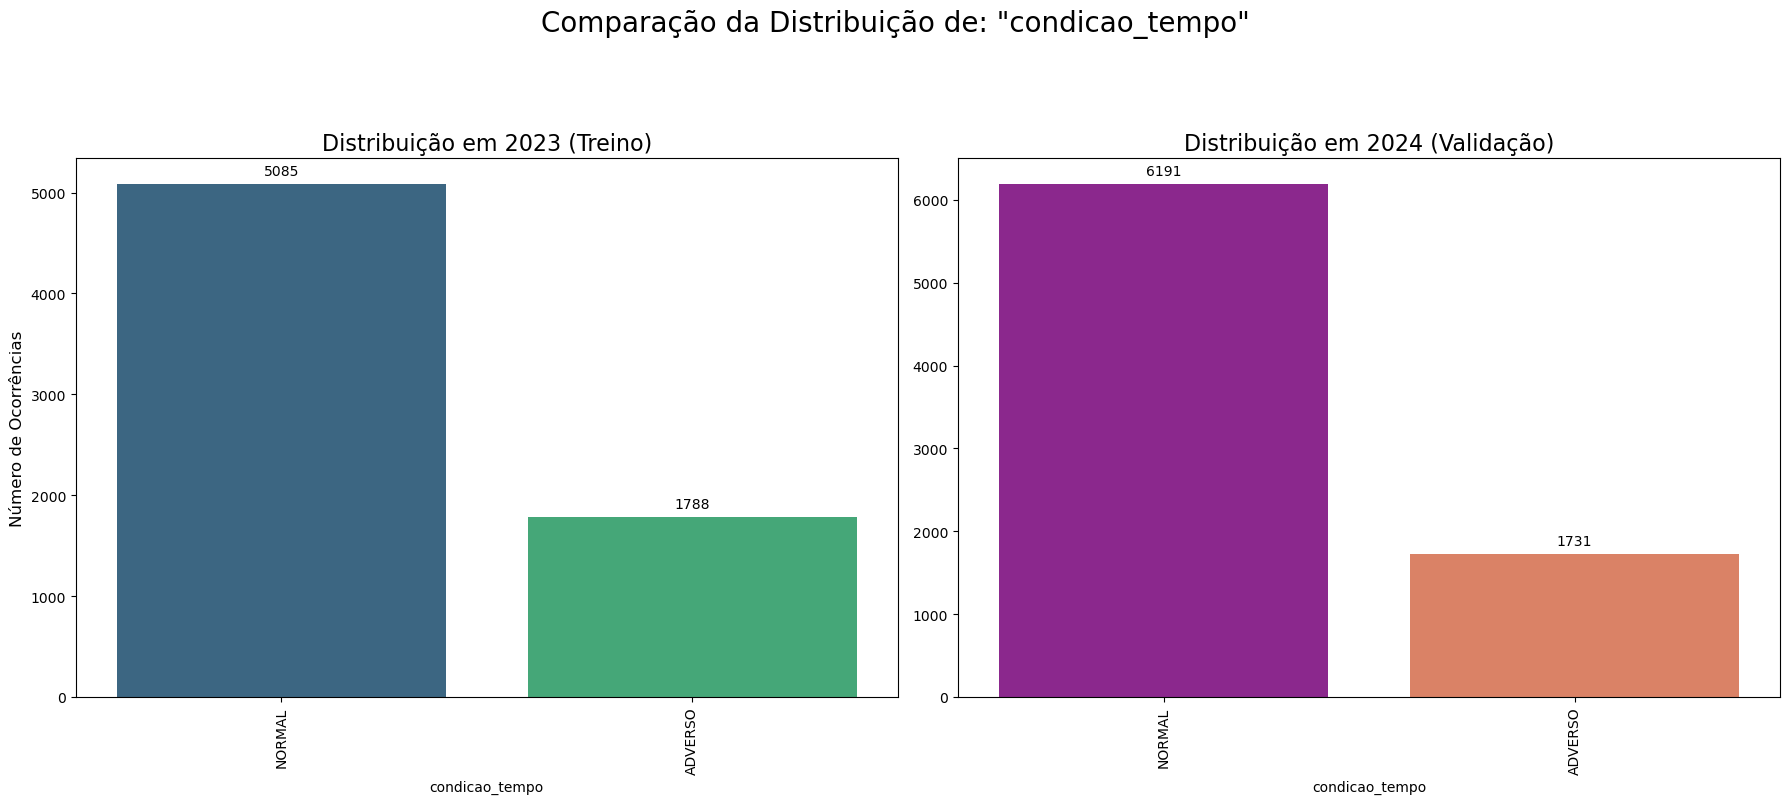

A gerar gráfico de comparação para a coluna: rodovia


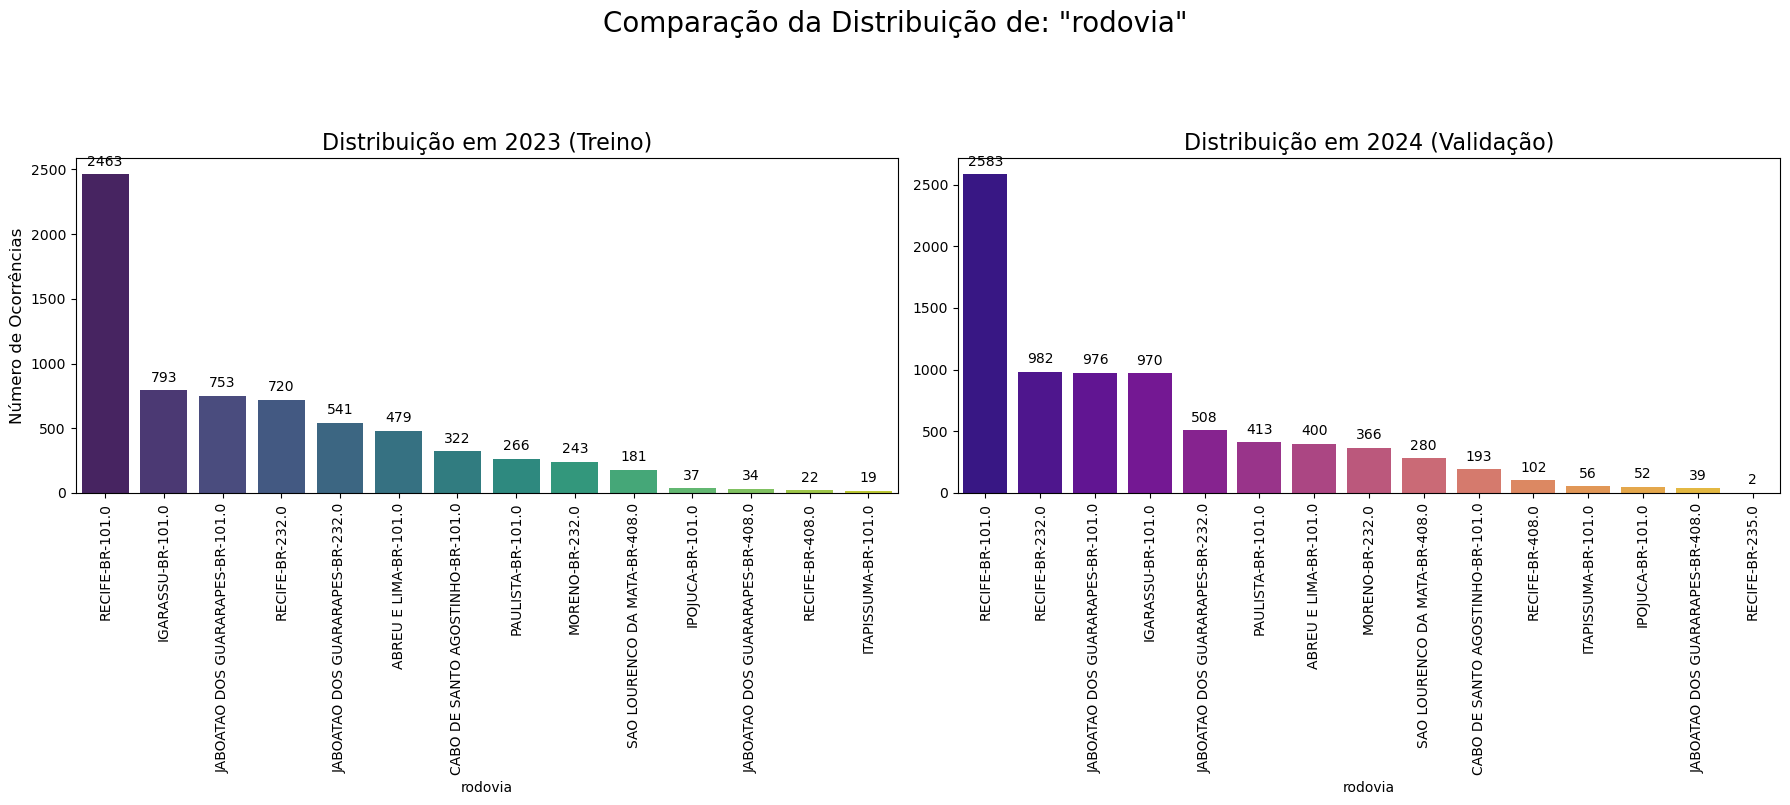

In [4]:
# Define os anos de 2023 para treinamento do modelo e o ano 2024 para testar o modelo.
ano_train_val = [2023, 2024]
# Seta o conjunto de dados de 2023 no df_train
df_train = df_clean[(df_clean['ano'] == ano_train_val[0])]
# Seta o conjunto de dados 2024 no df_val
df_val = df_clean[df_clean['ano'] == ano_train_val[1]]

# Define as colunas abaixo para geração de gráficos
colunas = [
    'classificacao_acidente',
    'tipo_acidente',
    'fase_dia',
    'tipo_pista',
    'tipo_veiculo',
    'tracado_via_unico',
    'final_semana',
    'condicao_tempo',
    'rodovia'
]

# Gera gráfico de 2023 na esquerda e 2024 na direita
for c in colunas:
    if c not in df_clean.columns:
        print(f"Aviso: A coluna '{c}' não foi encontrada no DataFrame. A saltar.")
        continue

    print(f"A gerar gráfico de comparação para a coluna: {c}")
    # 1. Criar a figura com dois subplots (1 linha, 2 colunas)
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # 2. Preparar os dados de contagem para ambos os anos
    contagem_train = df_train[c].value_counts()
    contagem_val = df_val[c].value_counts()

    # --- Gráfico 1: Ano de Treino (à esquerda) ---
    ax1 = axes[0]
    sns.barplot(
        x=contagem_train.index,
        y=contagem_train.values,
        palette='viridis',
        ax=ax1,
        hue=contagem_train.index,
        legend=False
    )
    ax1.set_title(f'Distribuição em {ano_train_val[0]} (Treino)', fontsize=16)
    ax1.set_ylabel('Número de Ocorrências', fontsize=12)
    ax1.tick_params(axis='x', rotation=90) # Rotacionar os rótulos do eixo X
    # Adicionar anotações de valor
    for p in ax1.patches:
        ax1.annotate(format(p.get_height(), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

    # --- Gráfico 2: Ano de Validação (à direita) ---
    ax2 = axes[1]
    sns.barplot(
        x=contagem_val.index,
        y=contagem_val.values,
        palette='plasma', # Usar uma paleta de cores diferente para distinção
        ax=ax2,
        hue=contagem_val.index,
        legend=False
    )
    ax2.set_title(f'Distribuição em {ano_train_val[1]} (Validação)', fontsize=16)
    ax2.set_ylabel('') # O rótulo do eixo Y já está no primeiro gráfico
    ax2.tick_params(axis='x', rotation=90) # Rotacionar os rótulos do eixo X
    # Adicionar anotações de valor
    for p in ax2.patches:
        ax2.annotate(format(p.get_height(), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

    # Adicionar um título geral para a figura inteira
    fig.suptitle(f'Comparação da Distribuição de: "{c}"', fontsize=20, y=1.03)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout para caber o título

    # Salvar a figura com um nome único para cada coluna
    plt.savefig(f'comparacao_{c}.png')
    plt.show()

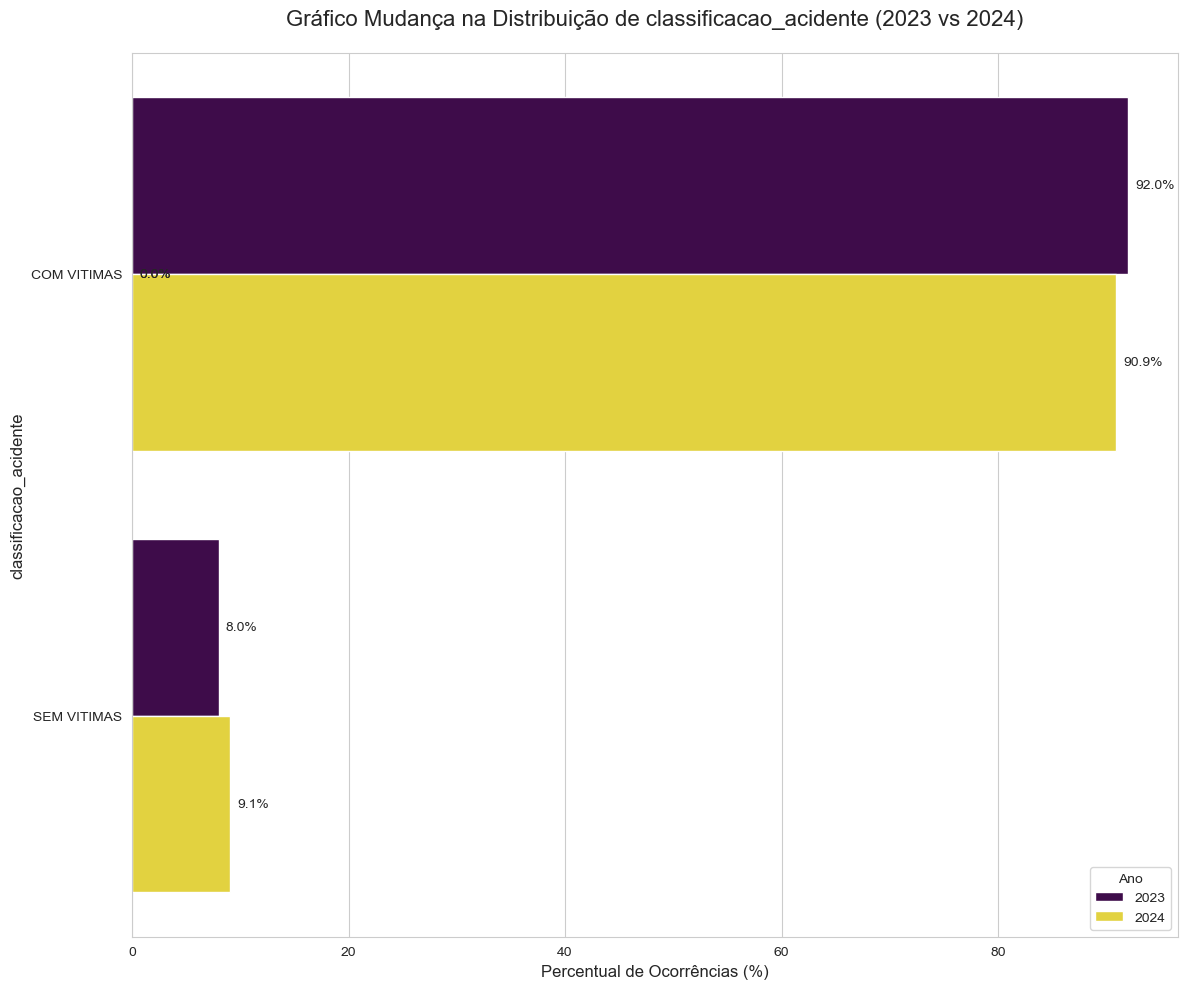

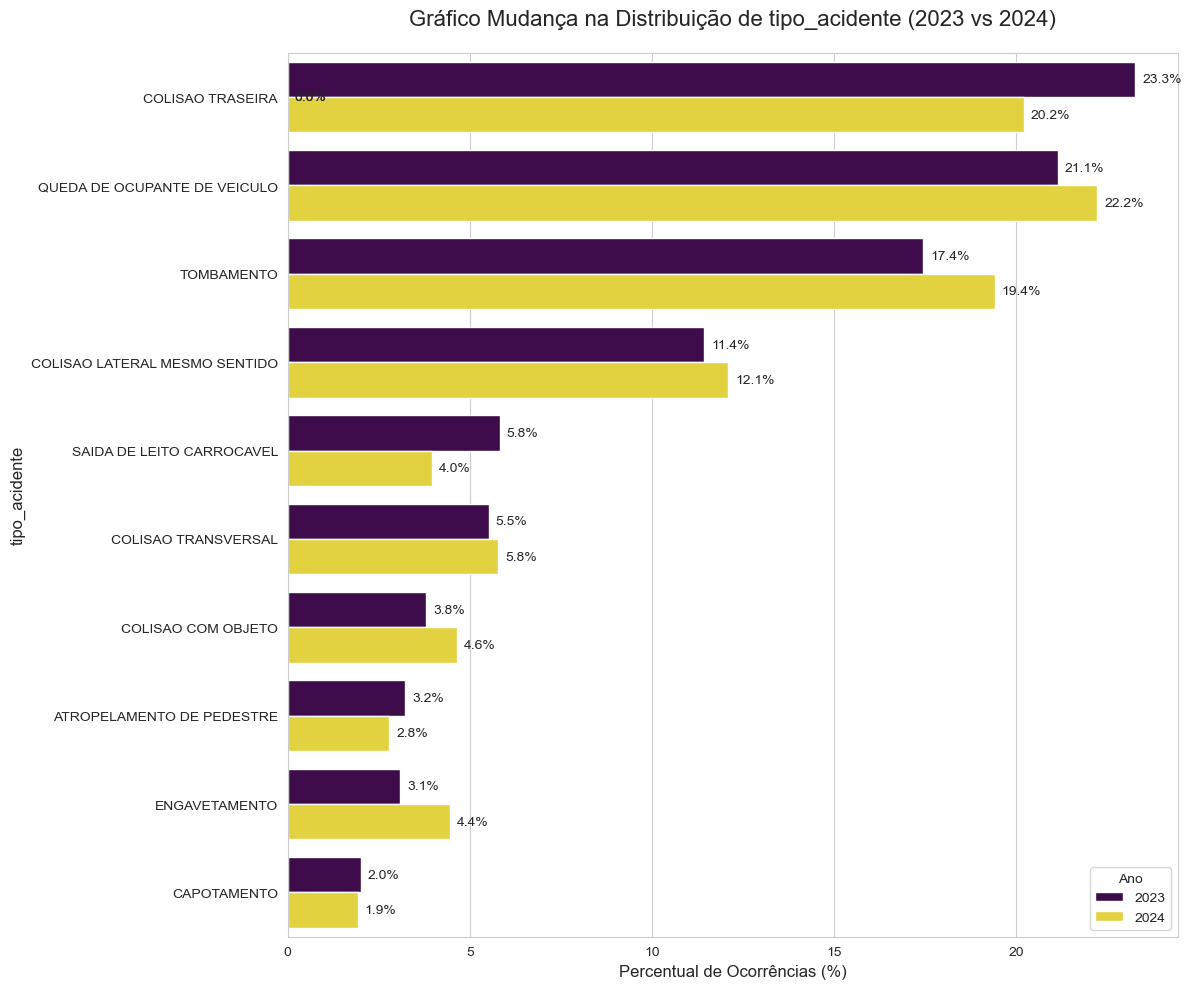

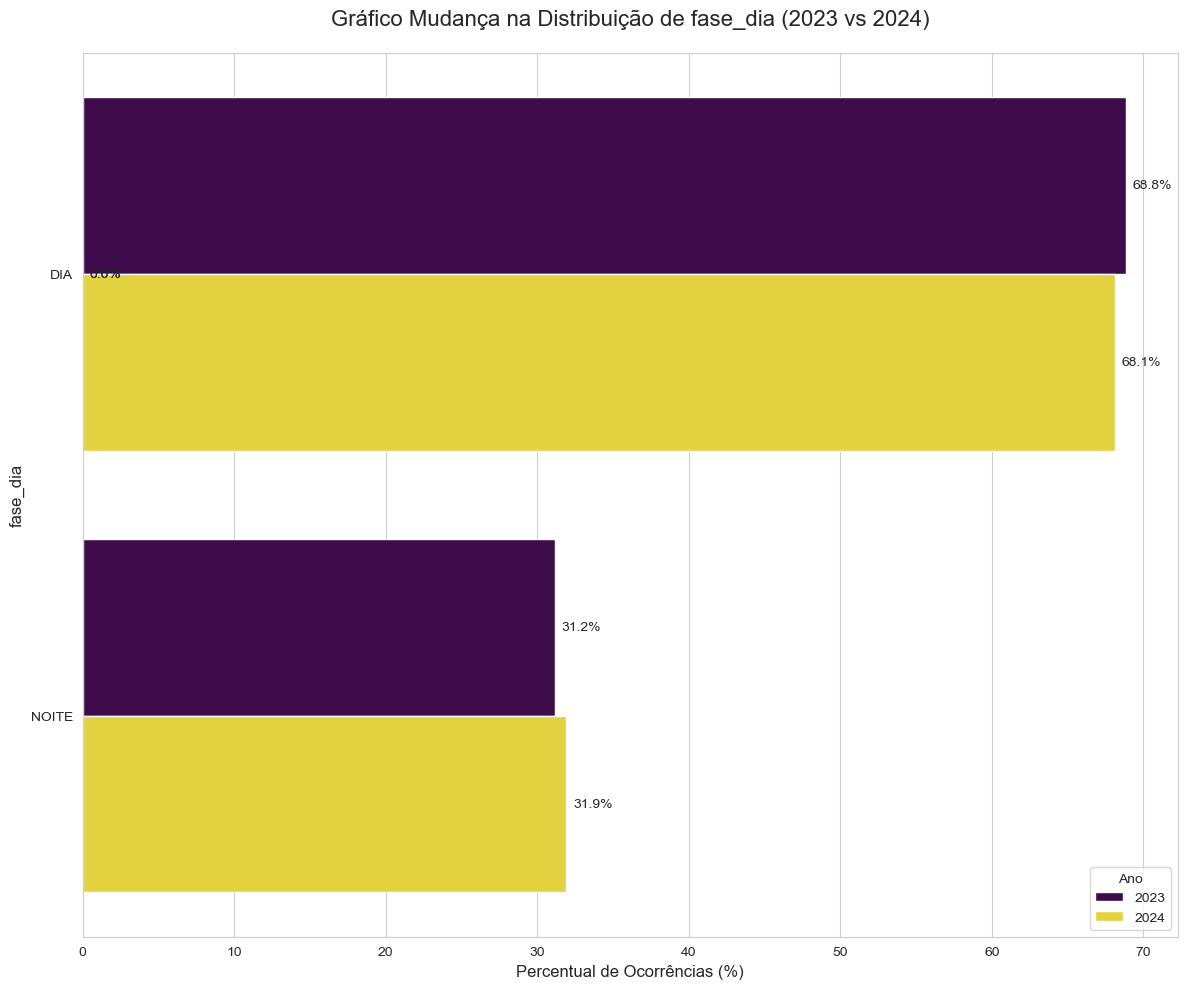

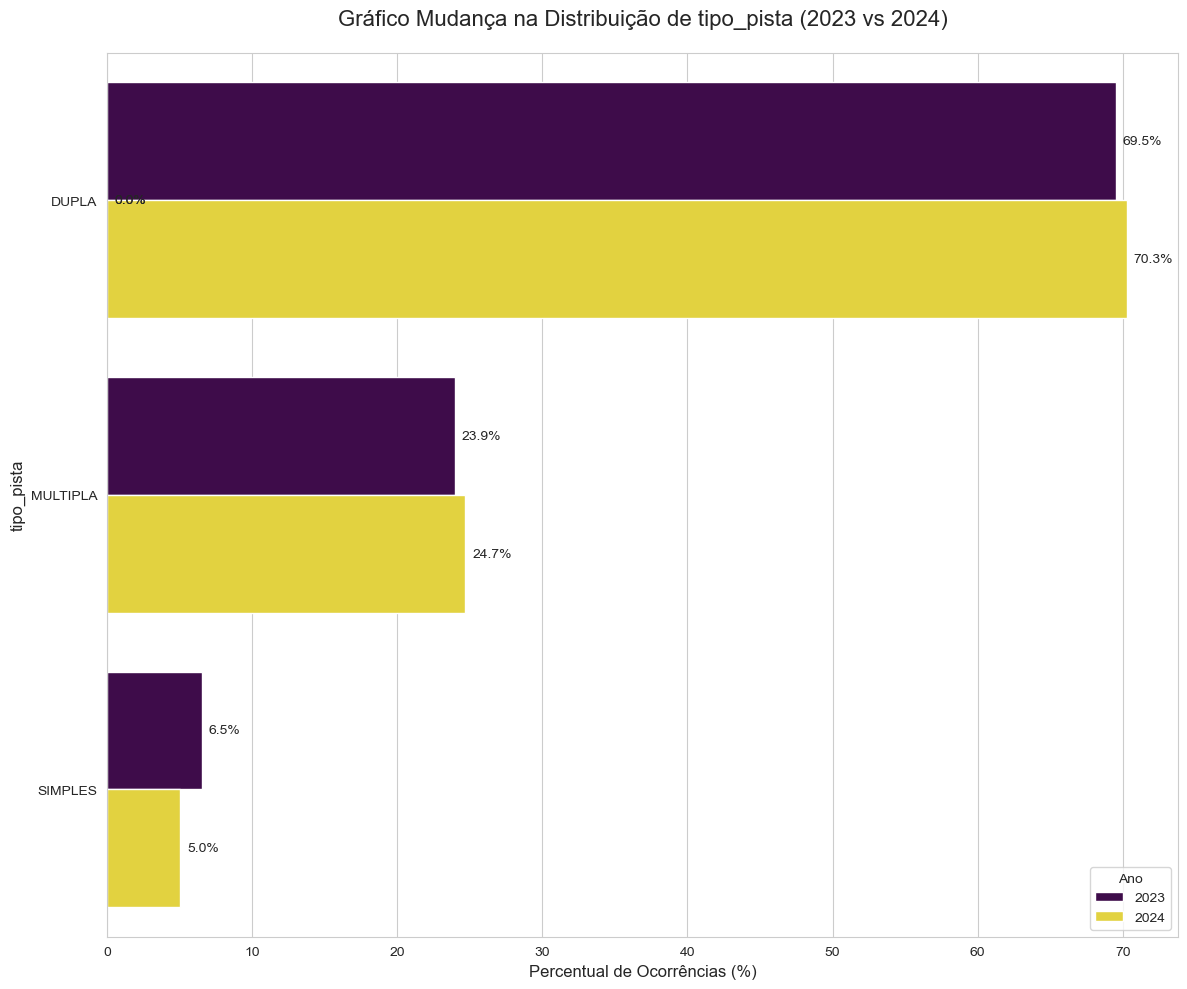

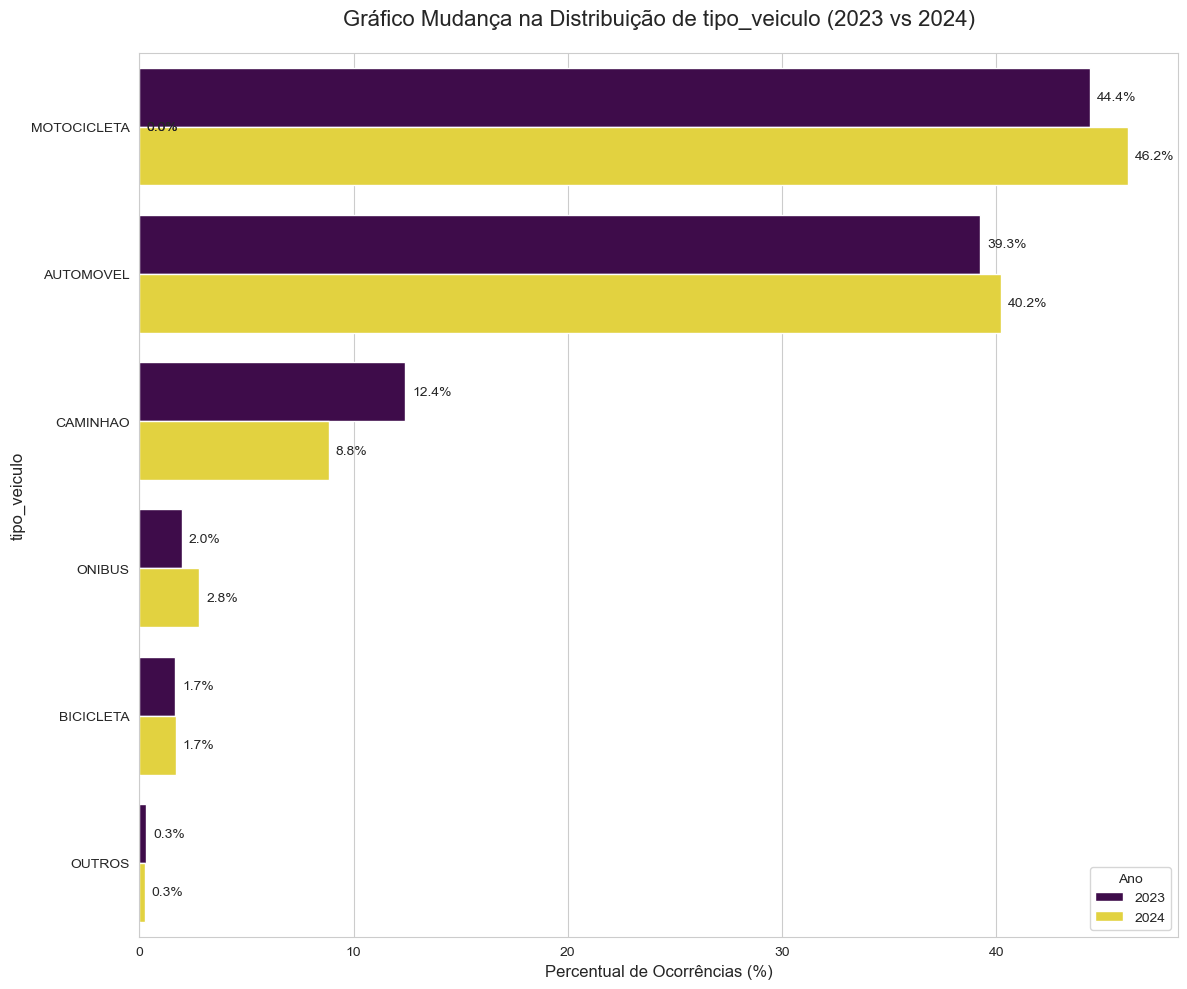

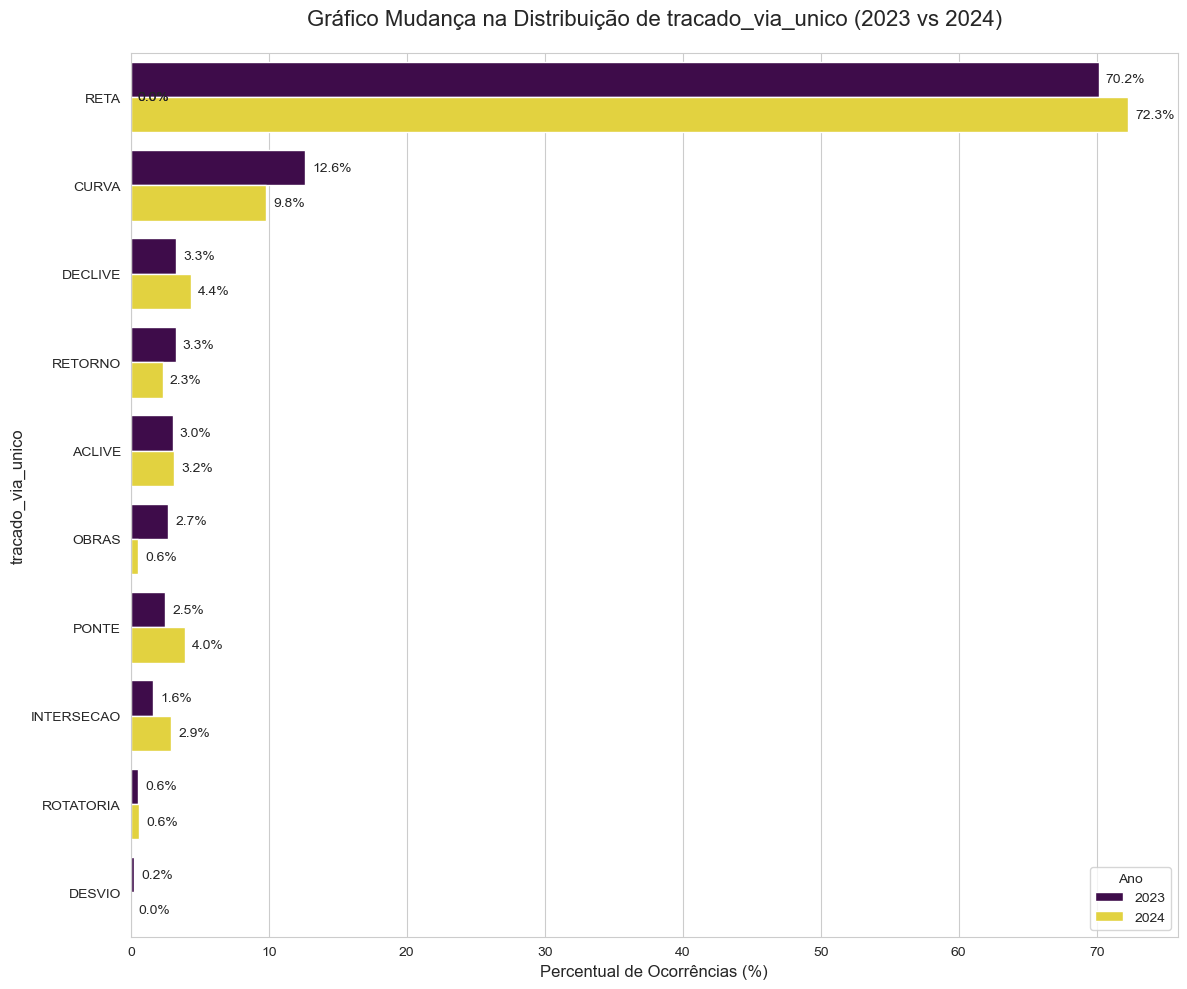

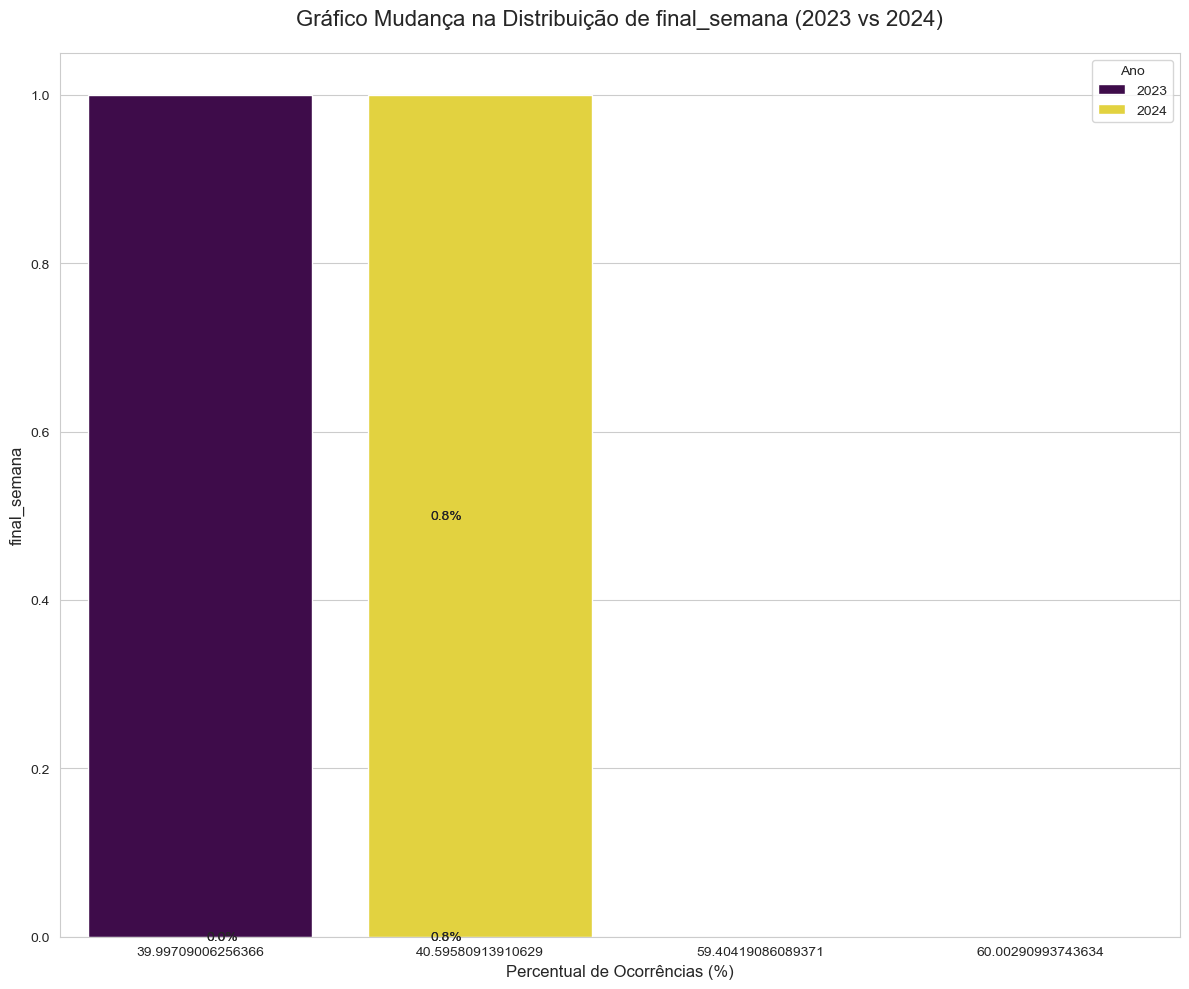

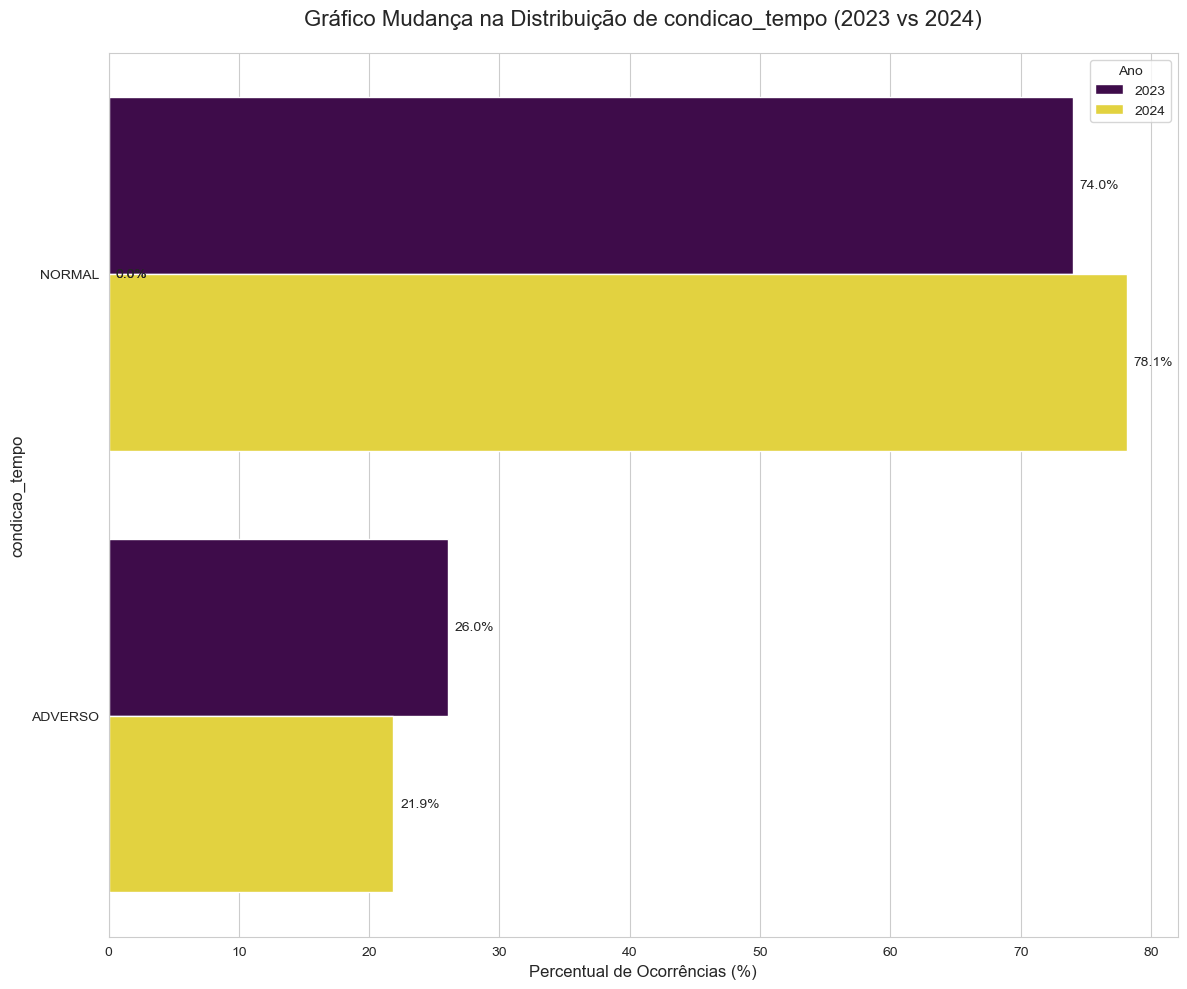

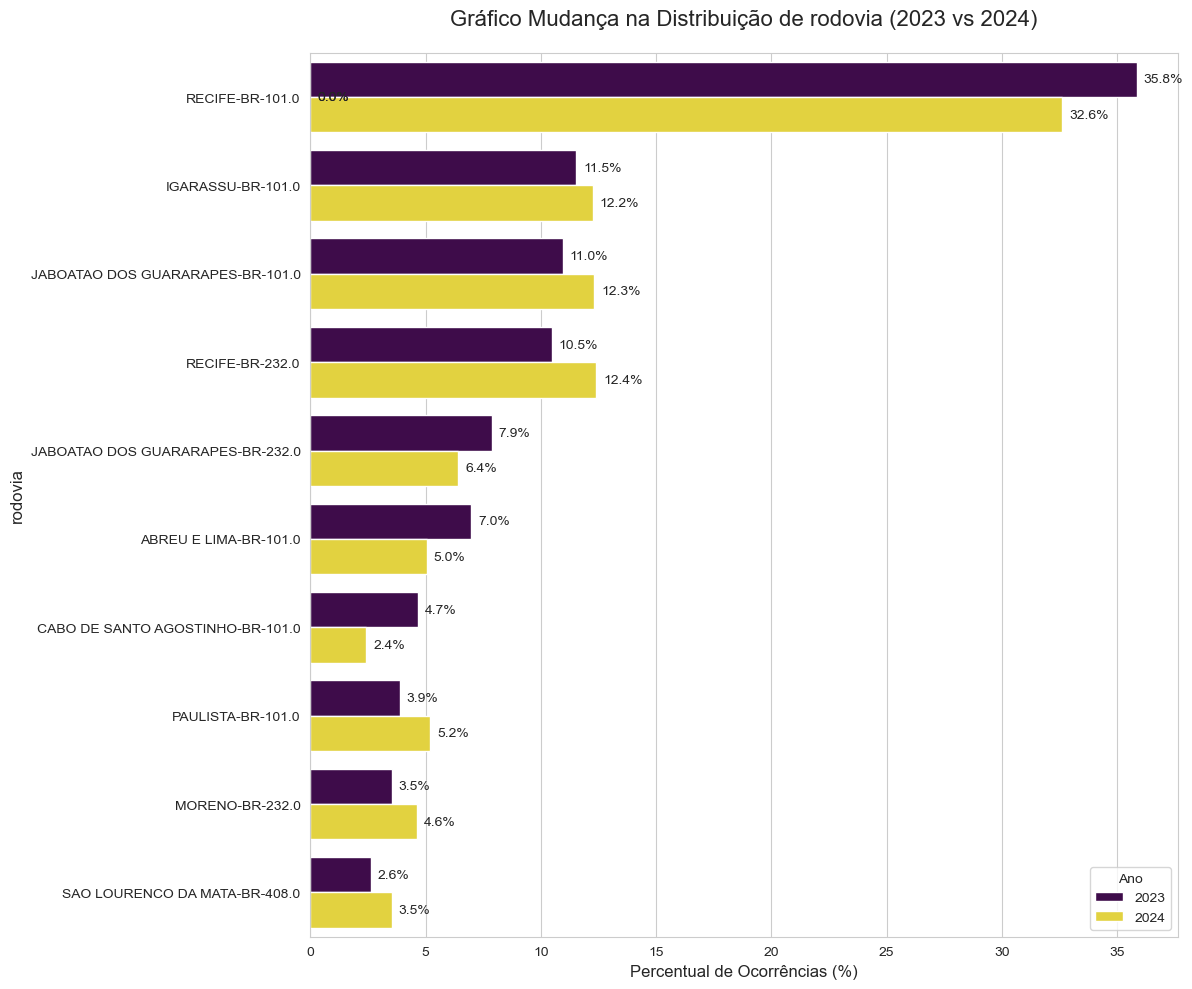



--- Fim da análise exploratória de dados ---


In [5]:
# Gerar gráficos para calcular a distribuição percentual para cada ano

# Define dois novos dataframes copiando de treino e validação
df_2023 = df_train.copy()
df_2024 = df_val.copy()

# Colunas para a geração dos gráficos comparativos
colunas = [
    'classificacao_acidente',
    'tipo_acidente',
    'fase_dia',
    'tipo_pista',
    'tipo_veiculo',
    'tracado_via_unico',
    'final_semana',
    'condicao_tempo',
    'rodovia'
]


for c in colunas:
    # realiza a distribuição dos dados de 2023
    dist_2023 = df_2023[c].value_counts(normalize=True).mul(100).rename('percentual').reset_index()
    # Cria a coluna ano com o valor 2023
    dist_2023['ano'] = 2023

    # realiza a distribuição dos dados de 2023
    dist_2024 = df_2024[c].value_counts(normalize=True).mul(100).rename('percentual').reset_index()
    # Cria a coluna ano com o valor 2024
    dist_2024['ano'] = 2024
    
    # Juntar os dados para a plotagem
    df_comparativo = pd.concat([dist_2023, dist_2024])
    
    # Filtrar para as 10 categorias mais comuns para manter o gráfico legível
    top_10_tipos = df_comparativo.groupby(c)['percentual'].sum().nlargest(10).index
    df_plot = df_comparativo[df_comparativo[c].isin(top_10_tipos)]
    
    # Criar o gráfico comparativo
    plt.figure(figsize=(12, 10))
    sns.set_style("whitegrid")
    
    barplot = sns.barplot(
        data=df_plot,
        y=c,
        x='percentual',
        hue='ano',
        palette='viridis'
    )
    
    # Adicionar títulos e rótulos
    plt.title(f'Gráfico Mudança na Distribuição de {c} (2023 vs 2024)', fontsize=16, pad=20)
    plt.xlabel('Percentual de Ocorrências (%)', fontsize=12)
    plt.ylabel(c, fontsize=12)
    plt.legend(title='Ano')

    for p in barplot.patches:
        # p.get_width() retorna o valor da barra (o percentual)
        # p.get_y() + p.get_height() / 2. encontra o meio da barra na vertical
        barplot.annotate(f'{p.get_width():.1f}%', # Formata o número com 1 casa decimal e adiciona '%'
                       (p.get_width(), p.get_y() + p.get_height() / 2.),
                       ha = 'left',   # Alinha o texto à esquerda da ponta da barra
                       va = 'center', # Centraliza verticalmente
                       xytext = (5, 0), # Adiciona um pequeno espaço da ponta da barra
                       textcoords = 'offset points',
                       fontsize=10)
    
    # Ajustar e salvar a imagem
    plt.tight_layout()
    plt.savefig(f'grafico_{c}_data_drift.png')
    plt.show()

print('\n\n--- Fim da análise exploratória de dados ---')

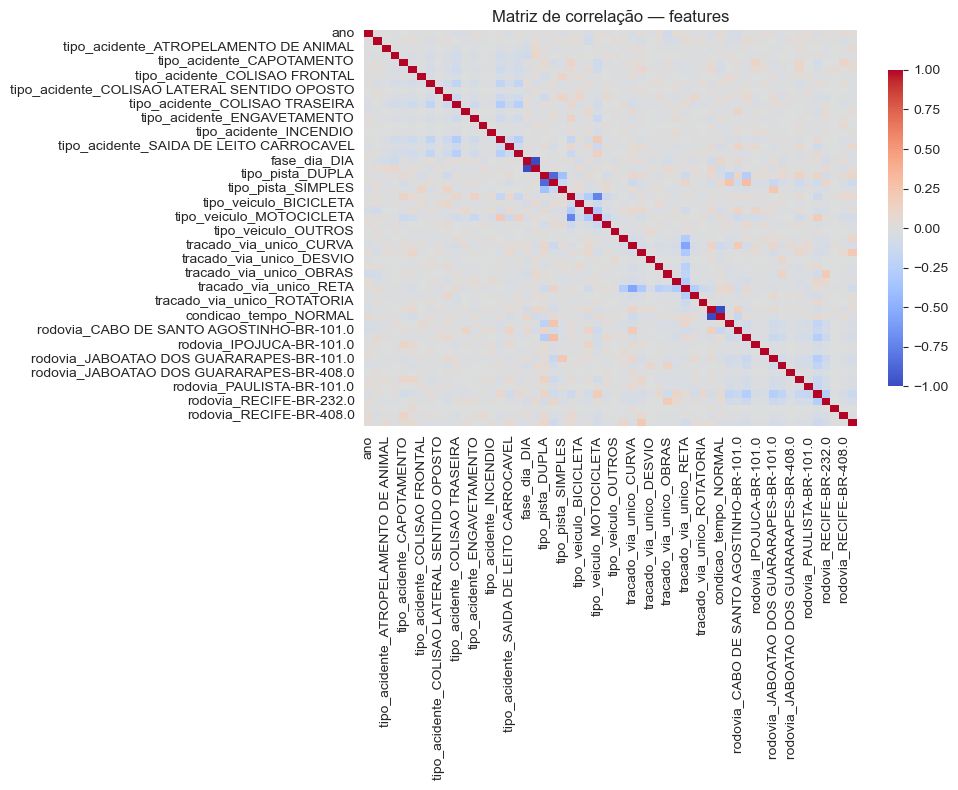

In [6]:
# GRAFICO DE CORRELAÇÃO COM ONE-HOT ENCONDING (DUMMIES)

# Remove a coluna de classe
X = df_clean.drop(columns=['classificacao_acidente'])
# Realiza o one-hot enconding das features
X_encoded_dum = pd.get_dummies(X)

# Gera o gráfico de correlação entre as features
plt.figure(figsize=(10,8))
corr = X_encoded_dum.corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title("Matriz de correlação — features")
plt.tight_layout()
plt.savefig(f'grafico_one_hot_encoding.png')

plt.show()


Matriz de Correlação:


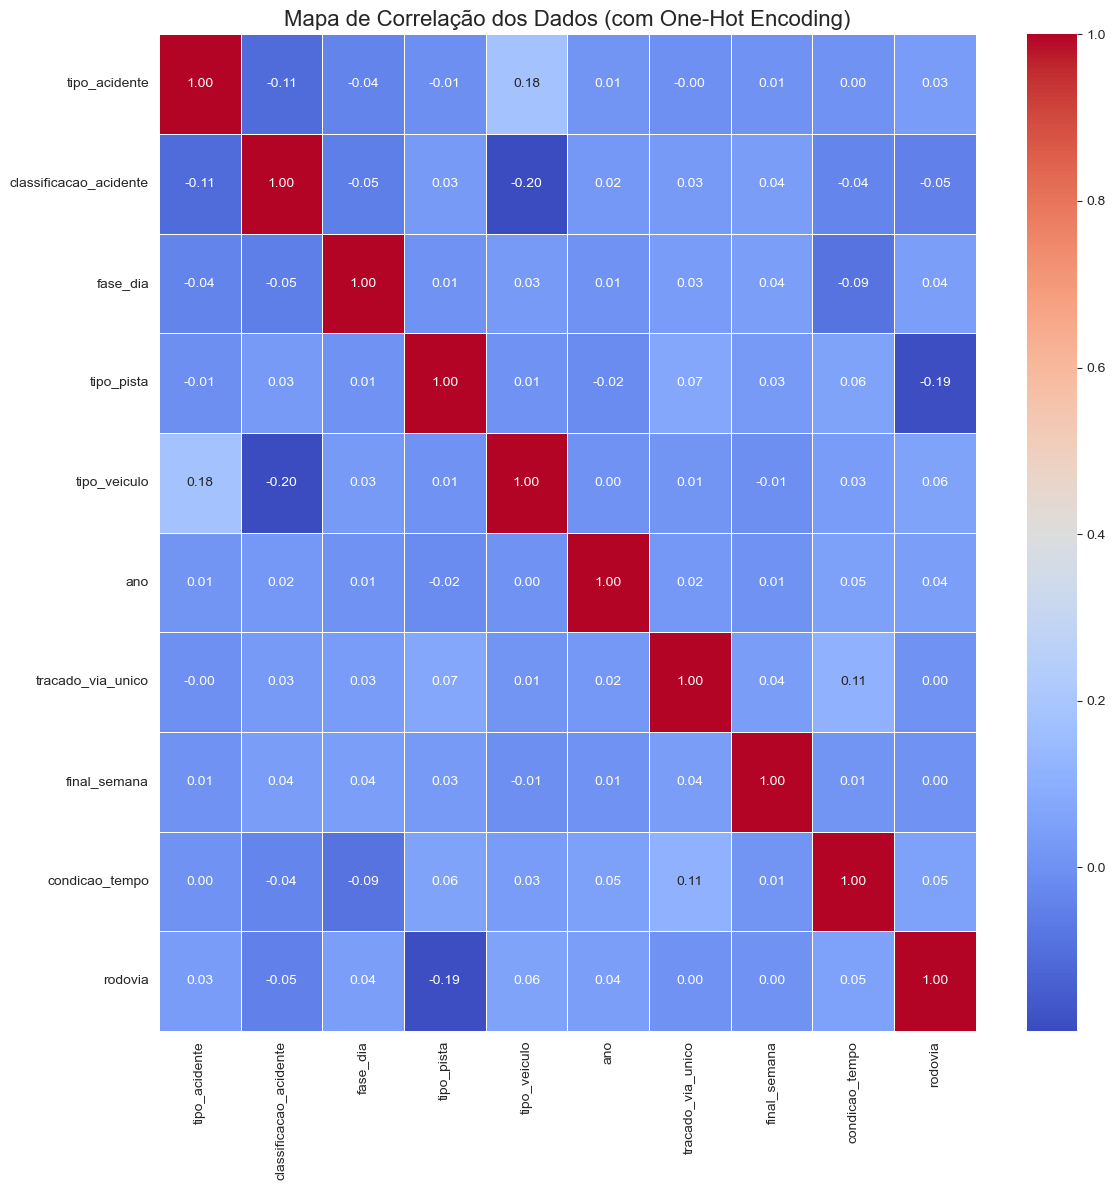

In [7]:
# GRAFICO DE CORRELAÇÃO COM LABEL ENCODER

df_encoded_label = df_clean.copy()
colunas_categoricas = df_encoded_label.select_dtypes(include='object').columns

# Label Encoding
for coluna in colunas_categoricas:
    le = LabelEncoder()
    df_encoded_label[coluna] = le.fit_transform(df_encoded_label[coluna])

print("\nMatriz de Correlação:")
matriz_correlacao = df_encoded_label.corr()
# Configurando o tamanho da figura para melhor visualização
plt.figure(figsize=(12, 12))

# Criando o heatmap da matriz de correlação
sns.heatmap(
    matriz_correlacao,
    annot=True,      
    cmap='coolwarm',   
    fmt=".2f",         
    linewidths=.5     
)

plt.title('Mapa de Correlação dos Dados (com One-Hot Encoding)', fontsize=16)
plt.tight_layout()
plt.savefig(f'grafico_label_encoder.png')

plt.show()

In [8]:
# TREINAMENTO DO MODELO XGBoost Treino 2023 - Teste 2024

# SEPARAÇÃO TEMPORAL DOS DADOS
# Dataframe de Treino recebe dados de 2023
X_train_temporal = df_clean[(df_clean['ano'] == ano_train_val[0])]
# Define a classe classificacao_acidente
y_train_temporal_texto = X_train_temporal['classificacao_acidente']

# Dataframe de Validação recebe dados de 2024
X_val_temporal = df_clean[df_clean['ano'] == ano_train_val[1]]
# Define a classe classificacao_acidente
y_val_temporal_texto = X_val_temporal['classificacao_acidente']

# Remover colunas que não são features do modelo
# classificao_acidente é a classe e ano como estamos segmentando somente por 2023 não faz sentido manter
X_train_temporal = X_train_temporal.drop(columns=['classificacao_acidente', 'ano'])
# classificao_acidente é a classe e ano como estamos segmentando somente por 2024 não faz sentido manter
X_val_temporal = X_val_temporal.drop(columns=['classificacao_acidente', 'ano'])

# ENCODING DAS VARIÁVEIS DE FEATURES UTILIZANDO DUMMIES
X_train_encoded = pd.get_dummies(X_train_temporal)
colunas_treino = X_train_encoded.columns
X_val_encoded = pd.get_dummies(X_val_temporal).reindex(columns=colunas_treino, fill_value=0)

# ENCODING DAS VARIÁVEIS DE CLASSE UTILIZANDO LABELENCODER (classificaçao binaria: COM VITIMA, SEM VITIMA)
le_alvo = LabelEncoder()
y_train_temporal = le_alvo.fit_transform(y_train_temporal_texto)
y_val_temporal = le_alvo.transform(y_val_temporal_texto)

# CÁLCULO MANUAL DE PESOS PARA TENTAR DAR PERFORMANCE NO TREINO POIS EXISTEM MUITO POUCO DADOS DE ACIDENTES SEM VITIMA
classe_sem_vitimas_encoded = le_alvo.transform(['SEM VITIMAS'])[0]
# O VALOR DE 2.5 FOI O MELHOR CUSTO/BENEFICIO ENCONTRADO
peso_para_sem_vitimas = 2.5 
pesos = np.where(y_train_temporal == classe_sem_vitimas_encoded, peso_para_sem_vitimas, 1)

# TREINAMENTO DO MODELO XGBOOST
print("\n--- Treinando o modelo XGBoost Binário com pesos manuais... ---")
# DEFINE OS CLASSIFICADORES PARA TENTAR MELHORAR A PERFORMANCE DO TREINAMENTO
modelo_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    base_score=0.5, 
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    max_delta_step=5,
    early_stopping_rounds=50
)

# REALIZA O TREINAMENTO DO MODELO
modelo_xgb.fit(
    X_train_encoded, 
    y_train_temporal, 
    sample_weight=pesos,
    eval_set=[(X_val_encoded, y_val_temporal)],
    verbose=False
)

print(f"Modelo treinado com sucesso!")
print(f"Melhor iteração (n_estimators ideal): {modelo_xgb.best_iteration}")

# AVALIAÇÃO FINAL
y_pred_val = modelo_xgb.predict(X_val_encoded)
accuracy = accuracy_score(y_val_temporal, y_pred_val)
print(f"\nAcurácia do modelo nos dados de validação (2024): {accuracy * 100:.2f}%")
print("\nRelatório de Classificação na Validação (2024):")
print(classification_report(y_val_temporal, y_pred_val, target_names=le_alvo.classes_))

# SALVANDO OS ARTEFATOS
# joblib.dump(modelo_xgb, 'modelo_xgb_binario.joblib')
# joblib.dump(le_alvo, 'label_encoder_alvo_binario.joblib')
# joblib.dump(colunas_treino, 'colunas_treino_binario.joblib')
print("\n--- Artefatos do modelo binário salvos com sucesso! ---")


--- Treinando o modelo XGBoost Binário com pesos manuais... ---
Modelo treinado com sucesso!
Melhor iteração (n_estimators ideal): 544

Acurácia do modelo nos dados de validação (2024): 89.69%

Relatório de Classificação na Validação (2024):
              precision    recall  f1-score   support

 COM VITIMAS       0.91      0.98      0.95      7203
 SEM VITIMAS       0.28      0.09      0.13       719

    accuracy                           0.90      7922
   macro avg       0.60      0.53      0.54      7922
weighted avg       0.86      0.90      0.87      7922


--- Artefatos do modelo binário salvos com sucesso! ---


In [9]:
# Treinamento do modelo com Randon Forest
from sklearn.ensemble import RandomForestClassifier 

# ENCODING DAS VARIÁVEIS DE FEATURES
X_train_encoded = pd.get_dummies(X_train_temporal)
colunas_treino = X_train_encoded.columns
X_val_encoded = pd.get_dummies(X_val_temporal).reindex(columns=colunas_treino, fill_value=0)

# ENCODING DA VARIÁVEL DE CLASSE
le_alvo = LabelEncoder()
y_train_temporal = le_alvo.fit_transform(y_train_temporal_texto)
y_val_temporal = le_alvo.transform(y_val_temporal_texto)

# --- TREINAMENTO DO MODELO RANDOM FOREST ---
print("\n--- Treinando o modelo Random Forest Binário... ---")

# MUDANÇA: Substituir o XGBClassifier pelo RandomForestClassifier
modelo_rf = RandomForestClassifier(
    n_estimators=200,          # Número de árvores na floresta. 200 é um bom ponto de partida.
    max_depth=10,              # Profundidade máxima para evitar sobreajuste. Comece com 10 e ajuste se necessário.
    class_weight='balanced',   # Lida com o desequilíbrio de classes automaticamente.
    random_state=42,           # Para garantir que os resultados sejam reproduzíveis.
    n_jobs=-1                  # Usa todos os processadores do seu computador para treinar mais rápido.
)

modelo_rf.fit(
    X_train_encoded, 
    y_train_temporal
)

print(f"Modelo treinado com sucesso!")

# --- AVALIAÇÃO FINAL ---
y_pred_val = modelo_rf.predict(X_val_encoded)
accuracy = accuracy_score(y_val_temporal, y_pred_val)
print(f"\nAcurácia do modelo nos dados de validação (2024): {accuracy * 100:.2f}%")
print("\nRelatório de Classificação na Validação (2024):")
print(classification_report(y_val_temporal, y_pred_val, target_names=le_alvo.classes_))

# --- SALVANDO OS ARTEFATOS ---
# MUDANÇA: Salvar o novo modelo e nomear os arquivos de forma correspondente
# joblib.dump(modelo_rf, 'modelo_rf_binario.joblib')
# joblib.dump(le_alvo, 'label_encoder_alvo_binario_rf.joblib')
# joblib.dump(colunas_treino, 'colunas_treino_binario_rf.joblib')
print("\n--- Artefatos do modelo Random Forest salvos com sucesso! ---")


--- Treinando o modelo Random Forest Binário... ---
Modelo treinado com sucesso!

Acurácia do modelo nos dados de validação (2024): 76.08%

Relatório de Classificação na Validação (2024):
              precision    recall  f1-score   support

 COM VITIMAS       0.95      0.77      0.85      7203
 SEM VITIMAS       0.22      0.62      0.32       719

    accuracy                           0.76      7922
   macro avg       0.58      0.70      0.59      7922
weighted avg       0.89      0.76      0.81      7922


--- Artefatos do modelo Random Forest salvos com sucesso! ---


In [10]:
# TREINAMENTO DO MODELO COM SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler 

# ENCODING DAS VARIÁVEIS DE FEATURES
X_train_encoded = pd.get_dummies(X_train_temporal)
colunas_treino = X_train_encoded.columns
X_val_encoded = pd.get_dummies(X_val_temporal).reindex(columns=colunas_treino, fill_value=0)

# ENCODING DA VARIÁVEL DE CLASSE
le_alvo = LabelEncoder()
y_train_temporal = le_alvo.fit_transform(y_train_temporal_texto)
y_val_temporal = le_alvo.transform(y_val_temporal_texto)

# SVM é muito sensível à escala dos dados. Este passo é crucial.
print("\n--- A escalar as features... ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# --- TREINAMENTO DO MODELO SVM ---
print("\n--- Treinando o modelo SVM (Support Vector Machine)... ---")

# SVC
modelo_svm = SVC(
    C=1.0,                     # Parâmetro de regularização.
    kernel='rbf',              # Kernel padrão e muito eficaz (Radial Basis Function).
    gamma='scale',             # Parâmetro do kernel. 'scale' é uma boa opção padrão.
    class_weight='balanced',   # Lida com o desequilíbrio de classes automaticamente.
    random_state=42
)

modelo_svm.fit(
    X_train_scaled,
    y_train_temporal
)

print(f"Modelo treinado com sucesso!")

# --- AVALIAÇÃO FINAL ---
y_pred_val = modelo_svm.predict(X_val_scaled)
accuracy = accuracy_score(y_val_temporal, y_pred_val)
print(f"\nAcurácia do modelo nos dados de validação (2024): {accuracy * 100:.2f}%")
print("\nRelatório de Classificação na Validação (2024):")
print(classification_report(y_val_temporal, y_pred_val, target_names=le_alvo.classes_))

# --- SALVANDO OS ARTEFATOS ---
# MUDANÇA: Salvar o novo modelo e o scaler, com nomes correspondentes
# joblib.dump(modelo_svm, 'modelo_svm_binario.joblib')
# joblib.dump(scaler, 'scaler_svm.joblib') # IMPORTANTE: Salvar o scaler!
# joblib.dump(le_alvo, 'label_encoder_alvo_binario_svm.joblib')
# joblib.dump(colunas_treino, 'colunas_treino_binario_svm.joblib')
print("\n--- Artefatos do modelo SVM salvos com sucesso! ---")


--- A escalar as features... ---

--- Treinando o modelo SVM (Support Vector Machine)... ---
Modelo treinado com sucesso!

Acurácia do modelo nos dados de validação (2024): 79.74%

Relatório de Classificação na Validação (2024):
              precision    recall  f1-score   support

 COM VITIMAS       0.93      0.84      0.88      7203
 SEM VITIMAS       0.19      0.39      0.26       719

    accuracy                           0.80      7922
   macro avg       0.56      0.61      0.57      7922
weighted avg       0.87      0.80      0.83      7922


--- Artefatos do modelo SVM salvos com sucesso! ---


In [11]:
from sklearn.tree import DecisionTreeClassifier
# ENCODING DAS VARIÁVEIS DE FEATURES
X_train_encoded = pd.get_dummies(X_train_temporal)
colunas_treino = X_train_encoded.columns
X_val_encoded = pd.get_dummies(X_val_temporal).reindex(columns=colunas_treino, fill_value=0)

# ENCODING DA VARIÁVEL DE CLASSE
le_alvo = LabelEncoder()
y_train_temporal = le_alvo.fit_transform(y_train_temporal_texto)
y_val_temporal = le_alvo.transform(y_val_temporal_texto)


# --- TREINAMENTO DO MODELO DECISION TREE ---
print("\n--- Treinando o modelo Decision Tree (Árvore de Decisão)... ---")

# DecisionTreeClassifier
modelo_dt = DecisionTreeClassifier(
    max_depth=10,              # Profundidade máxima. É o principal parâmetro para evitar sobreajuste.
    min_samples_split=20,      # Número mínimo de amostras para permitir uma nova divisão na árvore.
    min_samples_leaf=10,       # Número mínimo de amostras que uma folha (nó final) deve ter.
    class_weight='balanced',   # Lida com o desequilíbrio de classes automaticamente.
    random_state=42            # Para garantir que os resultados sejam reproduzíveis.
)

modelo_dt.fit(
    X_train_encoded, 
    y_train_temporal
)

print(f"Modelo treinado com sucesso!")

# --- AVALIAÇÃO FINAL ---
y_pred_val = modelo_dt.predict(X_val_encoded)
accuracy = accuracy_score(y_val_temporal, y_pred_val)
print(f"\nAcurácia do modelo nos dados de validação (2024): {accuracy * 100:.2f}%")
print("\nRelatório de Classificação na Validação (2024):")
print(classification_report(y_val_temporal, y_pred_val, target_names=le_alvo.classes_))

# --- SALVANDO OS ARTEFATOS ---
# MUDANÇA: Salvar o novo modelo com nomes correspondentes
# joblib.dump(modelo_dt, 'modelo_dt_binario.joblib')
# joblib.dump(le_alvo, 'label_encoder_alvo_binario_dt.joblib')
# joblib.dump(colunas_treino, 'colunas_treino_binario_dt.joblib')
print("\n--- Artefatos do modelo Decision Tree salvos com sucesso! ---")


--- Treinando o modelo Decision Tree (Árvore de Decisão)... ---
Modelo treinado com sucesso!

Acurácia do modelo nos dados de validação (2024): 66.52%

Relatório de Classificação na Validação (2024):
              precision    recall  f1-score   support

 COM VITIMAS       0.96      0.66      0.78      7203
 SEM VITIMAS       0.17      0.71      0.28       719

    accuracy                           0.67      7922
   macro avg       0.57      0.68      0.53      7922
weighted avg       0.89      0.67      0.74      7922


--- Artefatos do modelo Decision Tree salvos com sucesso! ---


In [12]:
# --- PREPARAÇÃO PARA O LIGHTGBM (SEM ONE-HOT ENCODING) ---
# Converter colunas de texto para o tipo 'category'
colunas_categoricas = X_train_temporal.select_dtypes(include='object').columns
for col in colunas_categoricas:
    X_train_temporal[col] = X_train_temporal[col].astype('category')
    X_val_temporal[col] = X_val_temporal[col].astype('category')

colunas_treino = X_train_temporal.columns

# ENCODING DA VARIÁVEL DE CLASSE
le_alvo = LabelEncoder()
y_train_temporal = le_alvo.fit_transform(y_train_temporal_texto)
y_val_temporal = le_alvo.transform(y_val_temporal_texto)

# CÁLCULO MANUAL DE PESOS
classe_sem_vitimas_encoded = le_alvo.transform(['SEM VITIMAS'])[0]
peso_para_sem_vitimas = 2.5
pesos = np.where(y_train_temporal == classe_sem_vitimas_encoded, peso_para_sem_vitimas, 1)


# --- TREINAMENTO DO MODELO LIGHTGBM ---
print("\n--- Treinando o modelo LightGBM Binário com pesos manuais... ---")

modelo_lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='logloss',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    bagging_fraction=0.8,
    feature_fraction=0.8,
    min_split_gain=1,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# O early stopping é passado através de um callback, e o eval_set é passado diretamente.
early_stopping_callback = lgb.early_stopping(
    stopping_rounds=50,
    verbose=False
)

# REALIZA O TREINAMENTO DO MODELO
modelo_lgbm.fit(
    X_train_temporal, 
    y_train_temporal, 
    sample_weight=pesos,
    eval_set=[(X_val_temporal, y_val_temporal)], # Passar o conjunto de validação
    eval_metric='logloss',                      # Especificar a métrica de avaliação
    callbacks=[early_stopping_callback]         # Passar o callback para parar cedo
)

print(f"Modelo treinado com sucesso!")
print(f"Melhor iteração (n_estimators ideal): {modelo_lgbm.best_iteration_}")

# AVALIAÇÃO FINAL
y_pred_val = modelo_lgbm.predict(X_val_temporal)
accuracy = accuracy_score(y_val_temporal, y_pred_val)
print(f"\nAcurácia do modelo nos dados de validação (2024): {accuracy * 100:.2f}%")
print("\nRelatório de Classificação na Validação (2024):")
print(classification_report(y_val_temporal, y_pred_val, target_names=le_alvo.classes_))

# SALVANDO OS ARTEFATOS
# joblib.dump(modelo_lgbm, 'modelo_lgbm_binario.joblib')
# joblib.dump(le_alvo, 'label_encoder_alvo_binario_lgbm.joblib')
# joblib.dump(colunas_treino, 'colunas_treino_binario_lgbm.joblib')
print("\n--- Artefatos do modelo LightGBM salvos com sucesso! ---")


--- Treinando o modelo LightGBM Binário com pesos manuais... ---
Modelo treinado com sucesso!
Melhor iteração (n_estimators ideal): 222

Acurácia do modelo nos dados de validação (2024): 89.55%

Relatório de Classificação na Validação (2024):
              precision    recall  f1-score   support

 COM VITIMAS       0.91      0.98      0.94      7203
 SEM VITIMAS       0.21      0.05      0.08       719

    accuracy                           0.90      7922
   macro avg       0.56      0.52      0.51      7922
weighted avg       0.85      0.90      0.87      7922


--- Artefatos do modelo LightGBM salvos com sucesso! ---


In [13]:
# TREINAMENTO DO MODELO XGBoost COM O ANO DE 2023+2024 QUEBRANDO EM 80% PARA TREINO E 20% PARA TESTE

# SEPARAÇÃO TEMPORAL DOS DADOS
# Dataframe de Treino recebe dados de 2023 + 2024
#
X = df_clean
# Define a classe classificacao_acidente
y_texto = X['classificacao_acidente']
# Define as features para treinament
print(f'Usando os anos: {X['ano'].unique()}')
X = X.drop(columns=['classificacao_acidente', 'ano'])

# ENCODING DAS VARIÁVEIS DE FEATURES UTILIZANDO DUMMIES
X_encoded = pd.get_dummies(X)
colunas_treino = X_train_encoded.columns

# ENCODING DA VARIÁVEL DE CLASSE UTILIZANDO LABELENCODER (classificaçao binaria: COM VITIMA, SEM VITIMA)
le = LabelEncoder()
y = le.fit_transform(y_texto)

# Separa 80% dos dados para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.2, 
    random_state=42, # Garante que a divisão seja sempre a mesma
    stratify=y      # Importante para manter a proporção das classes nos dois conjuntos
)


# CÁLCULO MANUAL DE PESOS PARA TENTAR DAR PERFORMANCE NO TREINO POIS EXISTEM MUITO POUCO DADOS DE ACIDENTES SEM VITIMA
#classe_sem_vitimas_encoded = le_alvo.transform(['SEM VITIMAS'])[0]
# O VALOR DE 2.5 FOI O MELHOR CUSTO/BENEFICIO ENCONTRADO
#peso_para_sem_vitimas = 2.5 
#pesos = np.where(y_train_temporal == classe_sem_vitimas_encoded, peso_para_sem_vitimas, 1)

# TREINAMENTO DO MODELO XGBOOST
print("\n--- Treinando o modelo XGBoost Binário 80/20... ---")
# DEFINE OS CLASSIFICADORES PARA TENTAR MELHORAR A PERFORMANCE DO TREINAMENTO
modelo_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    #base_score=0.5, 
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    #subsample=0.8,
    #colsample_bytree=0.8,
    #gamma=1,
    #max_delta_step=5,
    #early_stopping_rounds=50
)

# REALIZA O TREINAMENTO DO MODELO
modelo_xgb.fit(X_train, y_train)

print("Modelo treinado com sucesso!")

# Fazer previsões nos dados de teste (que o modelo nunca viu)
y_pred = modelo_xgb.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do modelo nos dados de teste: {accuracy * 100:.2f}%")

# Gerar um relatório de classificação mais detalhado
print("\nRelatório de Classificação:")
# Usamos o `le.classes_` para mostrar os nomes originais das classes no relatório
print(classification_report(y_test, y_pred, target_names=le.classes_))

# SALVANDO OS ARTEFATOS
#joblib.dump(modelo_xgb, 'modelo_xgb_8020.joblib')
#joblib.dump(le, 'label_encoder_alvo_8020.joblib')
#joblib.dump(colunas_treino, 'colunas_treino_8020.joblib')
print("\n--- Artefatos do modelo binário salvos com sucesso! ---")

Usando os anos: [2024 2023]

--- Treinando o modelo XGBoost Binário 80/20... ---
Modelo treinado com sucesso!

Acurácia do modelo nos dados de teste: 91.82%

Relatório de Classificação:
              precision    recall  f1-score   support

 COM VITIMAS       0.92      1.00      0.96      2705
 SEM VITIMAS       0.93      0.05      0.10       254

    accuracy                           0.92      2959
   macro avg       0.92      0.53      0.53      2959
weighted avg       0.92      0.92      0.88      2959


--- Artefatos do modelo binário salvos com sucesso! ---


In [14]:
# TREINAMENTO DO MODELO RandonForest COM O ANO DE 2023+2024 QUEBRANDO EM 80% PARA TREINO E 20% PARA TESTE
from sklearn.ensemble import RandomForestClassifier 

# SEPARAÇÃO TEMPORAL DOS DADOS
# Dataframe de Treino recebe dados de 2023 + 2024
#
X = df_clean
# Define a classe classificacao_acidente
y_texto = X['classificacao_acidente']
# Define as features para treinamento
print(f'Usando os anos: {X['ano'].unique()}')
X = X.drop(columns=['classificacao_acidente', 'ano'])

# ENCODING DAS VARIÁVEIS DE FEATURES
X_train_encoded = pd.get_dummies(X_train_temporal)
colunas_treino = X_train_encoded.columns
X_val_encoded = pd.get_dummies(X_val_temporal).reindex(columns=colunas_treino, fill_value=0)

# ENCODING DA VARIÁVEL DE CLASSE
le_alvo = LabelEncoder()
y_train_temporal = le_alvo.fit_transform(y_train_temporal_texto)
y_val_temporal = le_alvo.transform(y_val_temporal_texto)

# --- TREINAMENTO DO MODELO RANDOM FOREST ---
print("\n--- Treinando o modelo Random Forest Binário... ---")

# MUDANÇA: Substituir o XGBClassifier pelo RandomForestClassifier
modelo_rf = RandomForestClassifier(
    n_estimators=200,          # Número de árvores na floresta. 200 é um bom ponto de partida.
    max_depth=10,              # Profundidade máxima para evitar sobreajuste. Comece com 10 e ajuste se necessário.
    class_weight='balanced',   # Lida com o desequilíbrio de classes automaticamente.
    random_state=42,           # Para garantir que os resultados sejam reproduzíveis.
    n_jobs=-1                  # Usa todos os processadores do seu computador para treinar mais rápido.
)

modelo_rf.fit(
    X_train_encoded, 
    y_train_temporal
)

print(f"Modelo treinado com sucesso!")

# --- AVALIAÇÃO FINAL ---
y_pred_val = modelo_rf.predict(X_val_encoded)
accuracy = accuracy_score(y_val_temporal, y_pred_val)
print(f"\nAcurácia do modelo nos dados de validação (2024): {accuracy * 100:.2f}%")
print("\nRelatório de Classificação na Validação (2024):")
print(classification_report(y_val_temporal, y_pred_val, target_names=le_alvo.classes_))

# --- SALVANDO OS ARTEFATOS ---
# MUDANÇA: Salvar o novo modelo e nomear os arquivos de forma correspondente
joblib.dump(modelo_rf, 'modelo_rf_binario.joblib')
joblib.dump(le_alvo, 'label_encoder_alvo_binario_rf.joblib')
joblib.dump(colunas_treino, 'colunas_treino_binario_rf.joblib')
print("\n--- Artefatos do modelo Random Forest salvos com sucesso! ---")

Usando os anos: [2024 2023]

--- Treinando o modelo Random Forest Binário... ---
Modelo treinado com sucesso!

Acurácia do modelo nos dados de validação (2024): 76.08%

Relatório de Classificação na Validação (2024):
              precision    recall  f1-score   support

 COM VITIMAS       0.95      0.77      0.85      7203
 SEM VITIMAS       0.22      0.62      0.32       719

    accuracy                           0.76      7922
   macro avg       0.58      0.70      0.59      7922
weighted avg       0.89      0.76      0.81      7922


--- Artefatos do modelo Random Forest salvos com sucesso! ---


In [22]:
df_clean['rodovia'].unique()

array(['RECIFE-BR-101.0', 'JABOATAO DOS GUARARAPES-BR-101.0',
       'IGARASSU-BR-101.0', 'RECIFE-BR-232.0',
       'JABOATAO DOS GUARARAPES-BR-232.0', 'IPOJUCA-BR-101.0',
       'JABOATAO DOS GUARARAPES-BR-408.0', 'PAULISTA-BR-101.0',
       'CABO DE SANTO AGOSTINHO-BR-101.0', 'ABREU E LIMA-BR-101.0',
       'SAO LOURENCO DA MATA-BR-408.0', 'ITAPISSUMA-BR-101.0',
       'RECIFE-BR-408.0', 'MORENO-BR-232.0', 'RECIFE-BR-235.0'],
      dtype=object)